# Time Series Analysis of Gold (GLD) and Silver (SLV)

This notebook provides a comprehensive analysis of the historical close price data for **Gold (GLD)** and **Silver (SLV)**. The analysis encompasses the following key steps:

1. **Data Retrieval and Preparation**
   - Fetch historical price data for GLD and SLV.
   - Clean and preprocess the data to ensure accuracy and consistency.

2. **Seasonality Handling**
   - Identify and remove seasonal patterns through seasonal differencing.
   - Perform seasonal decomposition to extract trend, seasonal, and residual components.

3. **Stationarity Testing**
   - Assess the stationarity of the time series using the Augmented Dickey-Fuller (ADF) test with both AIC and BIC for lag selection.
   - Complement the ADF test with the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to confirm stationarity.

4. **Autocorrelation Analysis**
   - Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for both the trend and seasonal components of GLD and SLV.
   - Interpret these plots to understand the underlying patterns and dependencies in the data.

5. **Residuals Analysis**
   - Evaluate the residuals from the fitted models to ensure that they behave like white noise.
   - Plot residuals, their density, and their autocorrelations to diagnose model adequacy.

6. **Optimal Seasonality and Differencing**
   - Determine the optimal seasonal period for differencing and decomposition using autocorrelation analysis.
   - Identify the optimal number of differencing steps required to achieve stationarity.

Throughout the notebook, various Python libraries such as `pandas`, `numpy`, `matplotlib`, `seaborn`, and `statsmodels` are utilized to perform data manipulation, statistical testing, and visualization. Comprehensive logging is implemented to track the workflow and facilitate debugging.

**Purpose and Benefits:**
- **Data-Driven Insights:** Gain a deeper understanding of the price dynamics of Gold and Silver.
- **Model Reliability:** Ensure that the time series models are built on stationary data, enhancing forecasting accuracy.
- **Visual Diagnostics:** Use plots to intuitively assess the behavior of the time series components and residuals.
- **Automated Workflow:** Streamline the analysis process with functions that handle data retrieval, preprocessing, testing, and visualization.

By following this structured approach, the notebook aims to provide robust and insightful analysis of Gold and Silver price movements, supporting informed decision-making in financial contexts.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon.stocks import StocksClient
from polygon.rest import RESTClient
import logging
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks
import json

In [2]:
API_KEY = "uwQtl3txGt5BLbecq7ZbIu0ZbuitCGjc"

In [3]:

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Logs to console
        logging.FileHandler("app.log")  # Logs to a file named app.log
    ]
)

2024-10-22 17:45:01,911 - INFO - Initializing RESTClient for GLD...
2024-10-22 17:45:01,912 - INFO - Fetching aggregate bars data for 'GLD' from 2010-01-01 to 2024-09-01...
2024-10-22 17:45:02,485 - INFO - Converting response to DataFrame for GLD...


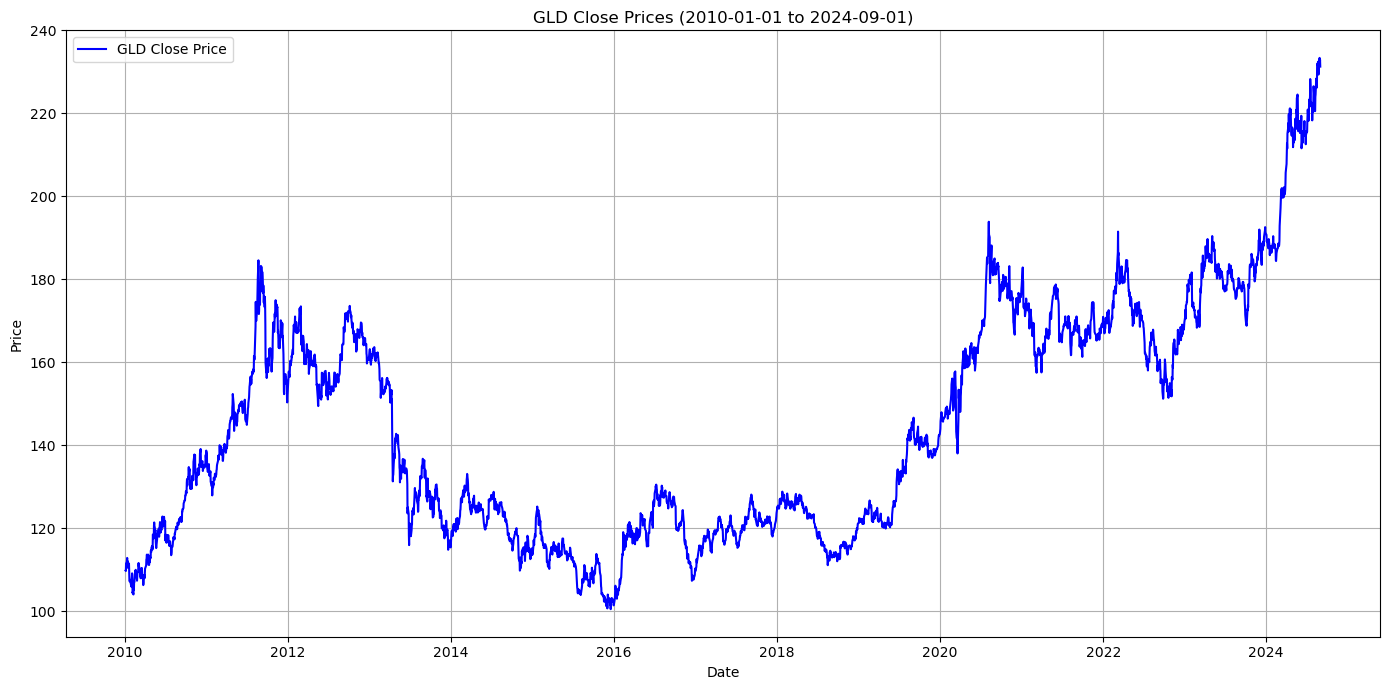

2024-10-22 17:45:02,915 - INFO - GLD prices saved to 'GLD-Prices.csv'.
2024-10-22 17:45:02,918 - INFO - Initializing RESTClient for SLV...
2024-10-22 17:45:02,918 - INFO - Fetching aggregate bars data for 'SLV' from 2010-01-01 to 2024-09-01...
2024-10-22 17:45:03,487 - INFO - Converting response to DataFrame for SLV...


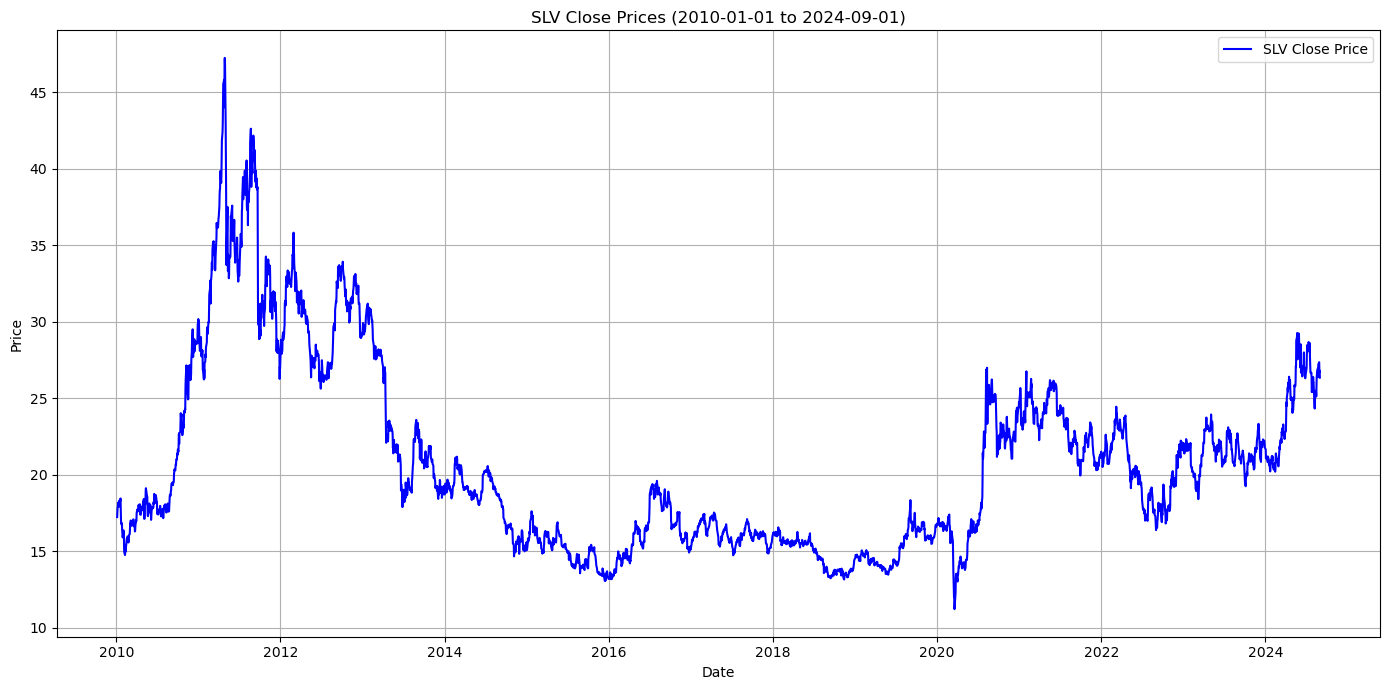

2024-10-22 17:45:03,651 - INFO - SLV prices saved to 'SLV-Prices.csv'.


In [4]:
def get_asset_data(ticker: str, start_date: str, end_date: str, plot=False):
    """
    Fetches historical price data for a given asset (e.g., GLD, SLV) between the specified start and end dates.
    
    Args:
        ticker (str): The ticker symbol (e.g., 'GLD', 'SLV').
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.
        plot (bool): Whether to plot the asset's close prices. Default is False.
        
    Returns:
        pd.DataFrame: DataFrame containing the historical price data for the asset.
    """
    try:
        logging.info(f"Initializing RESTClient for {ticker}...")
        rest_client = RESTClient(API_KEY)

        logging.info(
            f"Fetching aggregate bars data for '{ticker}' from {start_date} to {end_date}...")
        # Fetching daily aggregate data
        response = rest_client.get_aggs(
            ticker, 1, 'day', start_date, end_date, limit=50000
        )

        if not response:
            logging.error(
                f"Received empty response from RESTClient for {ticker}.")
            return None

        logging.info(f"Converting response to DataFrame for {ticker}...")
        data = [
            {
                't': item.timestamp,
                'o': item.open,
                'h': item.high,
                'l': item.low,
                'c': item.close,
                'v': item.volume
            }
            for item in response
        ]
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('Date', inplace=True)
        df.drop(columns=['t'], inplace=True)

        # Rename columns to match desired format
        df.rename(columns={
            'o': 'Open',
            'h': 'High',
            'l': 'Low',
            'c': 'Close',
            'v': 'Volume'
        }, inplace=True)

        # Convert numeric columns to proper type
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        df[numeric_columns] = df[numeric_columns].apply(
            pd.to_numeric, errors='coerce')

        # Optionally plot the data
        if plot:
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['Close'],
                     label=f'{ticker} Close Price', color='blue')
            plt.title(f'{ticker} Close Prices ({start_date} to {end_date})')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Save DataFrame to CSV
        csv_filename = f'{ticker}-Prices.csv'
        df.to_csv(csv_filename, index=True)
        logging.info(f"{ticker} prices saved to '{csv_filename}'.")

    except Exception as e:
        logging.error(f"An error occurred in get_asset_data: {e}")
        return None

    return df

# Fetch and plot GLD data
gld_data = get_asset_data('GLD', '2010-01-01', '2024-09-01', plot=True)

# Fetch and plot SLV data
slv_data = get_asset_data('SLV', '2010-01-01', '2024-09-01', plot=True)

# Seasonal Differencing and Decomposition Functions

## **Seasonal Differencing**

**Concept Overview:**
Seasonal differencing is a technique used in time series analysis to remove seasonal patterns from data. Seasonality refers to regular and predictable fluctuations that recur every specific period, such as daily, weekly, monthly, or yearly cycles. These patterns can obscure underlying trends and make it challenging to model and forecast the data accurately.

**Purpose:**
By applying seasonal differencing, we subtract the value of the series from its previous season (e.g., subtracting the value from 12 months ago in monthly data). This transformation helps in stabilizing the mean of the time series, making it more stationary and suitable for further analysis and modeling.

**Benefits:**
- **Enhances Stationarity:** Removes seasonal effects, leading to a more consistent mean and variance over time.
- **Improves Model Accuracy:** Facilitates the application of statistical models that assume stationarity, such as ARIMA.
- **Simplifies Forecasting:** Makes it easier to identify and model underlying trends without the interference of seasonal noise.

---

## **Seasonal Decomposition Analysis**

**Concept Overview:**
Seasonal decomposition breaks down a time series into its fundamental components: trend, seasonal, and residual (noise). This separation allows analysts to understand and interpret the different factors influencing the data.

**Purpose:**
The primary goal of seasonal decomposition is to isolate and examine each component individually. By doing so, we can gain insights into:
- **Trend:** The long-term progression or movement in the data (e.g., upward or downward trends).
- **Seasonal:** The repeating short-term cycles or patterns (e.g., increased sales during holidays).
- **Residual:** The irregular or random fluctuations that cannot be explained by trend or seasonality.

**Benefits:**
- **Enhanced Understanding:** Provides a clear view of the underlying structures within the data.
- **Improved Modeling:** Allows for more precise forecasting by modeling each component separately.
- **Anomaly Detection:** Helps in identifying outliers or unexpected changes in the residual component.

---

**In Summary:**
Both seasonal differencing and seasonal decomposition are essential tools in time series analysis for handling and understanding seasonality. Seasonal differencing focuses on removing seasonal patterns to achieve stationarity, while seasonal decomposition provides a detailed breakdown of the series into trend, seasonal, and residual components. Together, they enhance the accuracy and interpretability of time series models and forecasts.


In [5]:
def seasonal_differencing(series, seasonal_period):
    """
    Performs seasonal differencing on a time series.

    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The number of periods in a season (e.g., 7 for weekly seasonality).

    Returns:
        pd.Series: Seasonally differenced series.
    """
    try:
        logging.info(
            f"Performing seasonal differencing with period={seasonal_period}...")
        differenced = series.diff(seasonal_period).dropna()
        if differenced.empty:
            logging.warning(
                f"Seasonal differencing resulted in an empty series for period={seasonal_period}")
            return None
        logging.info("Seasonal differencing completed.")
        return differenced
    except Exception as e:
        logging.error(f"An error occurred during seasonal differencing: {e}")
        return None


def seasonal_decomposition_analysis(series, seasonal_period, model='additive'):
    """
    Performs seasonal decomposition on a time series.

    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The number of periods in a season.
        model (str): Type of seasonal component ('additive' or 'multiplicative').

    Returns:
        DecomposeResult: Object containing the trend, seasonal, and residual components.
    """
    try:
        logging.info(
            f"Performing seasonal decomposition with period={seasonal_period} and model='{model}'...")
        decomposition = seasonal_decompose(
            series, model=model, period=seasonal_period, extrapolate_trend='freq'
        )
        logging.info("Seasonal decomposition completed.")
        return decomposition
    except Exception as e:
        logging.error(f"An error occurred during seasonal decomposition: {e}")
        return None

# Augmented Dickey-Fuller (ADF) and KPSS Test Functions

## **`perform_adf_test` Function

**Purpose:**  
The `perform_adf_test` function conducts the Augmented Dickey-Fuller (ADF) test on a time series to determine its stationarity. Stationarity is a crucial property for many time series models, indicating that the statistical properties of the series remain constant over time.

**Concept Overview:**
- **Augmented Dickey-Fuller (ADF) Test:**  
  A statistical test used to assess whether a time series has a unit root, which implies non-stationarity. The ADF test helps in identifying the presence of a trend or other forms of non-stationarity in the data.

**Workflow:**
1. **Seasonal Differencing:**  
   The function first removes seasonal patterns from the data by applying seasonal differencing. This step stabilizes the mean of the series by eliminating regular seasonal fluctuations.
   
2. **Visualization:**  
   After differencing, the function plots the transformed series. Visual inspection of this plot aids in assessing the stationarity of the series.
   
3. **ADF Testing:**  
   The ADF test is then performed on the seasonally differenced series. The results, including the test statistic and p-value, indicate whether the series is stationary.

**Key Outcomes:**
- **Test Statistic & p-value:**  
  These values help in determining whether to reject the null hypothesis of non-stationarity.
  
- **Decision Making:**  
  A low p-value suggests rejecting the null hypothesis, indicating that the series is stationary.

---

## **`perform_kpss_test` Function

**Purpose:**  
The `perform_kpss_test` function executes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on a time series to evaluate its stationarity. Unlike the ADF test, the KPSS test has a different null hypothesis, providing complementary insights into the stationarity of the data.

**Concept Overview:**
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
  A statistical test used to examine whether a time series is stationary around a deterministic trend (trend-stationary) or has a unit root (non-stationary). The KPSS test assesses the null hypothesis that an observable time series is stationary.

**Workflow:**
1. **Seasonal Differencing:**  
   Similar to the ADF test function, KPSS begins by removing seasonal effects through seasonal differencing, ensuring that the test focuses on the underlying trend and residual components.
   
2. **Visualization:**  
   The seasonally differenced series is plotted to provide a visual assessment of its stationarity, aiding in the interpretation of the test results.
   
3. **KPSS Testing:**  
   The KPSS test is performed on the transformed series. The results, including the test statistic and p-value, help determine the stationarity of the series.

**Key Outcomes:**
- **Test Statistic & p-value:**  
  These metrics are used to decide whether to reject the null hypothesis of stationarity.
  
- **Decision Making:**  
  A low p-value indicates rejecting the null hypothesis, suggesting that the series is non-stationary.

---

## **Summary**

Both `perform_adf_test` and `perform_kpss_test` functions are integral for assessing the stationarity of time series data, a fundamental assumption for many forecasting models. By incorporating seasonal differencing and visualizations, these functions provide a comprehensive analysis:

- **`perform_adf_test`:**  
  Focuses on identifying unit roots to determine stationarity, with the null hypothesis being non-stationarity.

- **`perform_kpss_test`:**  
  Evaluates stationarity with the null hypothesis being stationarity, offering a complementary perspective to the ADF test.

Together, these functions enable robust diagnostics of time series data, ensuring that subsequent modeling efforts are based on sound statistical foundations.


In [6]:
async def perform_adf_test(ticker, series, seasonal_period=7, verbose=False):
    """
    Performs the Augmented Dickey-Fuller test on a seasonally differenced series using both AIC and BIC for lag selection.

    Parameters:
        ticker (str): The ticker symbol (e.g., 'GLD').
        series (pd.Series): The original time series data.
        seasonal_period (int): The number of periods in a season.

    Returns:
        dict: A dictionary containing the test results for both AIC and BIC.
    """
    try:
        logging.info("Starting ADF test with seasonal differencing...")

        # Perform seasonal differencing
        differenced = seasonal_differencing(series, seasonal_period)
        if differenced is None or differenced.empty:
            logging.warning(
                f"ADF test: No valid data after differencing for {ticker}.")
            return None

        # Plot the seasonally differenced data (if verbose)
        if verbose:
            logging.info(
                "Plotting seasonally differenced data for ADF test...")
            plt.figure(figsize=(14, 7))
            plt.plot(differenced.index, differenced,
                     label='Seasonally Differenced Close Price', color='green')
            plt.title(
                f'Seasonally Differenced {ticker} Close Prices (Period={seasonal_period})')
            plt.xlabel('Date')
            plt.ylabel('Differenced Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        differenced = differenced.dropna()
        if differenced.empty:
            logging.error(
                f"No data available after differencing for ADF test on {ticker}.")
            return None

        # Define the information criteria to use
        info_criteria = ['AIC', 'BIC']
        adf_results = {}

        for criterion in info_criteria:
            logging.info(
                f"Performing ADF test using {criterion} for lag selection...")
            adf_test = adfuller(differenced, autolag=criterion)

            adf_output = {
                'Test Statistic': adf_test[0],
                'p-value': adf_test[1],
                'Used Lag': adf_test[2],
                'Number of Observations': adf_test[3],
                'Critical Values': adf_test[4],
                'IC Best': adf_test[5]
            }

            adf_results[f'ADF Test ({criterion})'] = adf_output

        return adf_results

    except Exception as e:
        logging.error(f"An error occurred during ADF test for {ticker}: {e}")
        return None


async def perform_kpss_test(ticker, series, seasonal_period=7, regression='c', verbose=False):
    """
    Performs the KPSS test on a seasonally differenced series.

    Parameters:
        ticker (str): The ticker symbol (e.g., 'GLD').
        series (pd.Series): The original time series data.
        seasonal_period (int): The number of periods in a season.
        regression (str): Type of regression to include in the test ('c' or 'ct').

    Returns:
        dict: A dictionary containing the test results.
    """
    try:
        logging.info("Starting KPSS test with seasonal differencing...")

        differenced = seasonal_differencing(series, seasonal_period)
        if differenced is None or differenced.empty:
            logging.warning(
                f"KPSS test: No valid data after differencing for {ticker}.")
            return None

        if verbose:
            logging.info(
                "Plotting seasonally differenced data for KPSS test...")
            plt.figure(figsize=(14, 7))
            plt.plot(differenced.index, differenced,
                     label='Seasonally Differenced Close Price', color='purple')
            plt.title(
                f'Seasonally Differenced {ticker} Close Prices (Period={seasonal_period})')
            plt.xlabel('Date')
            plt.ylabel('Differenced Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        differenced = differenced.dropna()
        if differenced.empty:
            logging.error(
                f"No data available after differencing for KPSS test on {ticker}.")
            return None

        kpss_result = kpss(differenced, regression=regression, nlags="auto")

        kpss_output = {
            'Test Statistic': kpss_result[0],
            'p-value': kpss_result[1],
            'Lags Used': kpss_result[2],
            'Critical Values': kpss_result[3]
        }

        return kpss_output

    except Exception as e:
        logging.error(f"An error occurred during KPSS test for {ticker}: {e}")
        return None

# GLD Data Retrieval and Stationarity Testing

This workflow outlines the steps to fetch historical **GLD** (SPDR Gold Shares) close price data, assess its stationarity, and save the analysis results for future reference.

## **Workflow Steps**

1. **Data Retrieval**
   - **Fetch GLD Data:**  
     Retrieve historical close price data for the GLD ticker from January 1, 2019, to September 1, 2024.
   - **Validation:**  
     Ensure that the data retrieval was successful. If not, log an error and halt the process.

2. **Stationarity Testing**
   - **Augmented Dickey-Fuller (ADF) Test:**  
     Assess whether the GLD time series is stationary. A stationary series has constant statistical properties over time, which is essential for reliable forecasting.
   - **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
     Complement the ADF test by evaluating the stationarity of the series from a different perspective. While ADF tests for non-stationarity, KPSS tests for stationarity.

3. **Results Compilation**
   - **Aggregate Test Results:**  
     Combine the outcomes of both the ADF and KPSS tests into a single dictionary for easy interpretation.

4. **Logging and Saving**
   - **Log Test Results:**  
     Record the test results in the logging system to keep a record of the analysis.
   - **Save to JSON:**  
     Export the compiled test results to a JSON file (`GLD_Test_Results.json`) for persistent storage and future analysis.

## **Purpose and Benefits**

- **Data Integrity:**  
  Ensures that only valid and successfully retrieved data is processed, preventing errors in subsequent analysis.
  
- **Comprehensive Analysis:**  
  Utilizing both ADF and KPSS tests provides a robust assessment of the time series' stationarity, leveraging the strengths of each test.
  
- **Record Keeping:**  
  Saving results to a JSON file allows for easy access, sharing, and integration with other tools or reports.

## **Conclusion**

By following this workflow, you can effectively retrieve GLD close price data, evaluate its stationarity, and maintain a clear record of your analysis. This process is fundamental for time series forecasting and financial analysis, ensuring that models are built on stable and reliable data foundations.


2024-10-22 17:45:03,722 - INFO - Starting ADF test with seasonal differencing...
2024-10-22 17:45:03,724 - INFO - Performing seasonal differencing with period=7...
2024-10-22 17:45:03,727 - INFO - Seasonal differencing completed.
2024-10-22 17:45:03,728 - INFO - Plotting seasonally differenced data for ADF test...


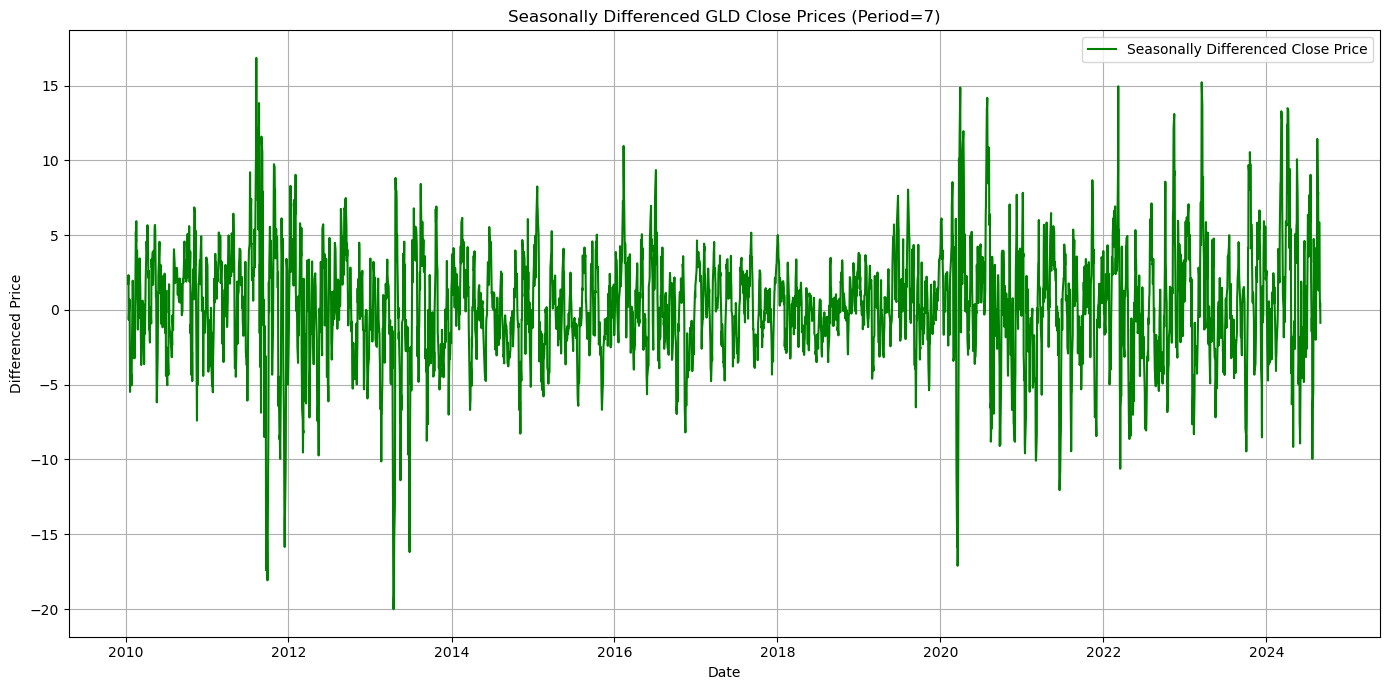

2024-10-22 17:45:03,888 - INFO - Performing ADF test using AIC for lag selection...
2024-10-22 17:45:04,622 - INFO - Performing ADF test using BIC for lag selection...
2024-10-22 17:45:05,227 - INFO - Starting KPSS test with seasonal differencing...
2024-10-22 17:45:05,229 - INFO - Performing seasonal differencing with period=7...
2024-10-22 17:45:05,239 - INFO - Seasonal differencing completed.
2024-10-22 17:45:05,240 - INFO - Plotting seasonally differenced data for KPSS test...


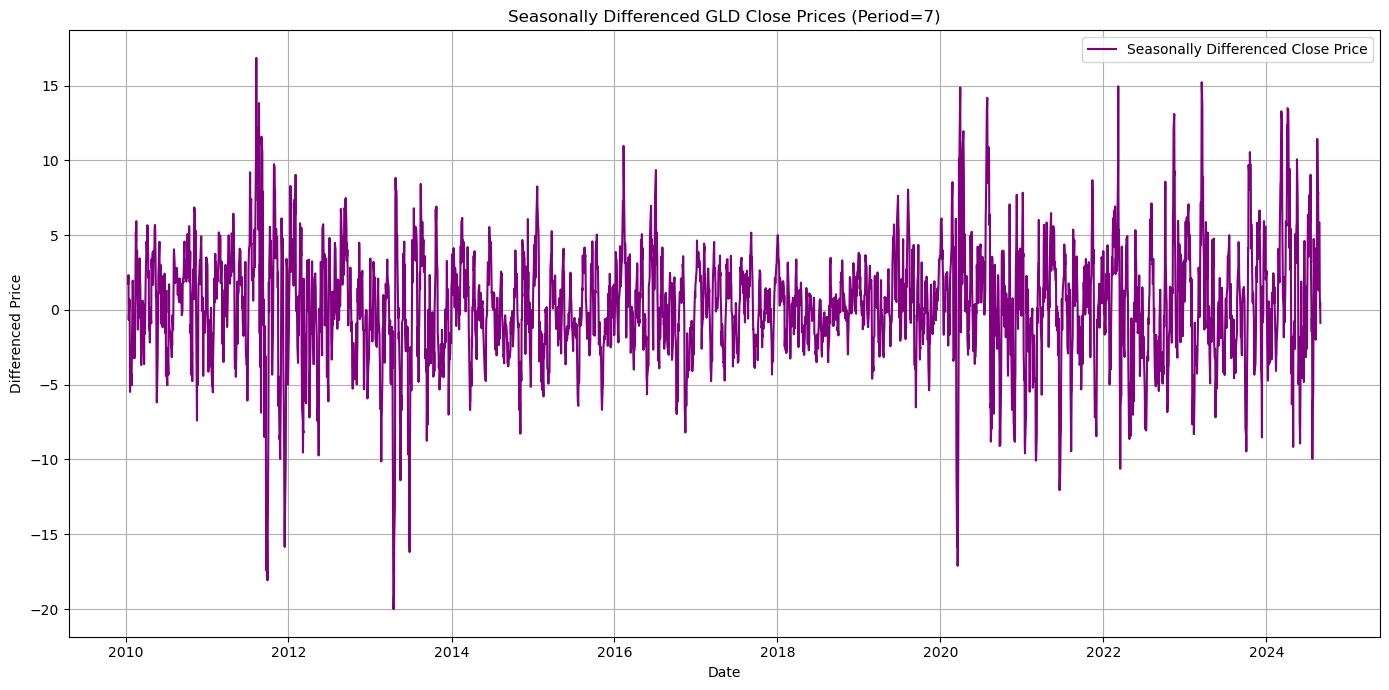

/var/folders/2c/trmbhl295p74b6v9kd24x24h0000gn/T/ipykernel_72159/4294001504.py:115: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(differenced, regression=regression, nlags="auto")
2024-10-22 17:45:05,499 - INFO - Test results saved to 'GLD_Test_Results.json'.


In [7]:


# Perform ADF Test
adf_results = await perform_adf_test('GLD', gld_data['Close'], verbose=True)
if adf_results is None:
    logging.error("ADF test failed.")

# Perform KPSS Test
# Use 'ct' if you want to include a trend
kpss_results = await perform_kpss_test('GLD', gld_data['Close'], regression='ct', verbose=True)
if kpss_results is None:
    logging.error("KPSS test failed.")

# Prepare the test results dictionary
test_results = {
    'ADF Test': adf_results,
    'KPSS Test': kpss_results
}

# Save the test results to a JSON file
json_filename = 'GLD_Test_Results.json'
try:
    with open(json_filename, 'w') as json_file:
        json.dump(test_results, json_file, indent=4, default=str)
    logging.info(f"Test results saved to '{json_filename}'.")
except Exception as e:
    logging.error(f"Failed to save test results to JSON: {e}")

# SLV Data Retrieval and Stationarity Testing

This workflow outlines the steps to fetch historical **SLV** (iShares Silver Trust) close price data, assess its stationarity, and save the analysis results for future reference.

## **Workflow Steps**

1. **Data Retrieval**
   - **Fetch SLV Data:**  
     Retrieve historical close price data for the SLV ticker from January 1, 2019, to September 1, 2024.
   - **Validation:**  
     Ensure that the data retrieval was successful. If not, log an error and halt the process.

2. **Stationarity Testing**
   - **Augmented Dickey-Fuller (ADF) Test:**  
     Assess whether the SLV time series is stationary. A stationary series has constant statistical properties over time, which is essential for reliable forecasting.
   - **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
     Complement the ADF test by evaluating the stationarity of the series from a different perspective. While ADF tests for non-stationarity, KPSS tests for stationarity.

3. **Results Compilation**
   - **Aggregate Test Results:**  
     Combine the outcomes of both the ADF and KPSS tests into a single dictionary for easy interpretation.

4. **Logging and Saving**
   - **Log Test Results:**  
     Record the test results in the logging system to keep a record of the analysis.
   - **Save to JSON:**  
     Export the compiled test results to a JSON file (`SLV_Test_Results.json`) for persistent storage and future analysis.

## **Purpose and Benefits**

- **Data Integrity:**  
  Ensures that only valid and successfully retrieved data is processed, preventing errors in subsequent analysis.
  
- **Comprehensive Analysis:**  
  Utilizing both ADF and KPSS tests provides a robust assessment of the time series' stationarity, leveraging the strengths of each test.
  
- **Record Keeping:**  
  Saving results to a JSON file allows for easy access, sharing, and integration with other tools or reports.

## **Conclusion**

By following this workflow, you can effectively retrieve SLV close price data, evaluate its stationarity, and maintain a clear record of your analysis. This process is fundamental for time series forecasting and financial analysis, ensuring that models are built on stable and reliable data foundations.


2024-10-22 17:45:05,508 - INFO - Starting ADF test with seasonal differencing...
2024-10-22 17:45:05,509 - INFO - Performing seasonal differencing with period=7...
2024-10-22 17:45:05,513 - INFO - Seasonal differencing completed.
2024-10-22 17:45:05,514 - INFO - Plotting seasonally differenced data for ADF test...


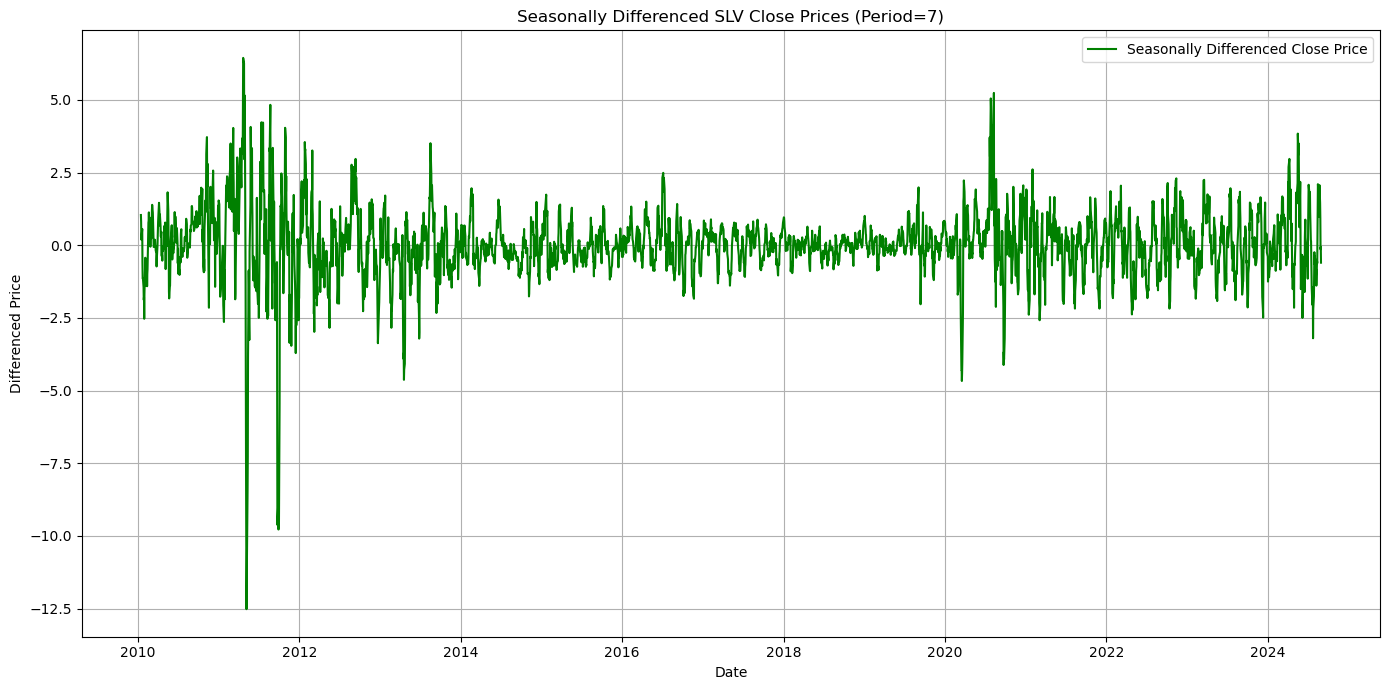

2024-10-22 17:45:05,659 - INFO - Performing ADF test using AIC for lag selection...
2024-10-22 17:45:06,199 - INFO - Performing ADF test using BIC for lag selection...
2024-10-22 17:45:06,989 - INFO - Starting KPSS test with seasonal differencing...
2024-10-22 17:45:07,000 - INFO - Performing seasonal differencing with period=7...
2024-10-22 17:45:07,002 - INFO - Seasonal differencing completed.
2024-10-22 17:45:07,003 - INFO - Plotting seasonally differenced data for KPSS test...


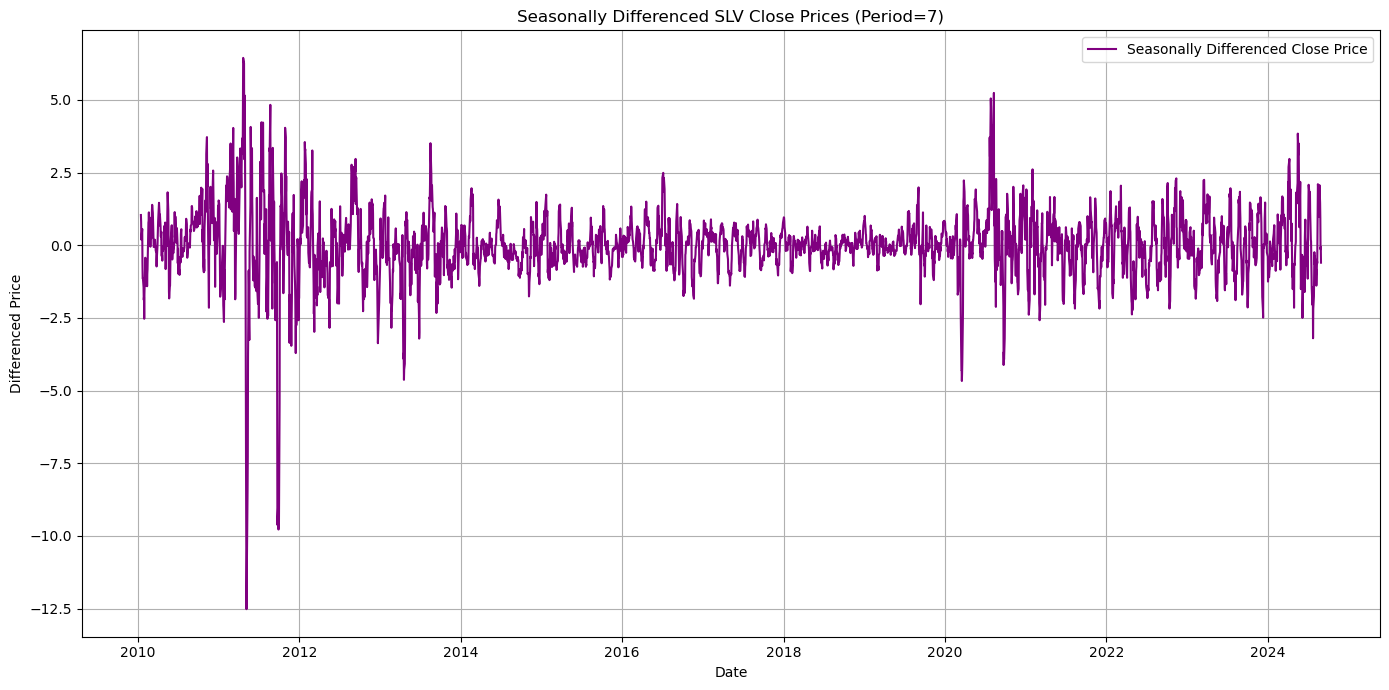

/var/folders/2c/trmbhl295p74b6v9kd24x24h0000gn/T/ipykernel_72159/4294001504.py:115: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(differenced, regression=regression, nlags="auto")
2024-10-22 17:45:07,253 - INFO - Test results saved to 'SLV_Test_Results.json'.


In [8]:

# Perform ADF Test
adf_results = await perform_adf_test('SLV', slv_data['Close'], verbose=True)
if adf_results is None:
    logging.error("ADF test failed.")

# Perform KPSS Test
kpss_results = await perform_kpss_test('SLV', slv_data['Close'], regression='c', verbose=True)  # Use 'ct' if you want to include a trend
if kpss_results is None:
    logging.error("KPSS test failed.")

# Prepare the test results dictionary
test_results = {
    'ADF Test': adf_results,
    'KPSS Test': kpss_results
}

# Save the test results to a JSON file
json_filename = 'SLV_Test_Results.json'
try:
    with open(json_filename, 'w') as json_file:
        json.dump(test_results, json_file, indent=4, default=str)
    logging.info(f"Test results saved to '{json_filename}'.")
except Exception as e:
    logging.error(f"Failed to save test results to JSON: {e}")

# Optimal Seasonal Period Determination

In time series analysis, identifying the correct seasonal period is crucial for accurately modeling and forecasting data with recurring patterns. The **`find_optimal_seasonal_period`** function serves this purpose by analyzing the **Autocorrelation Function (ACF)** of the time series data to determine the most appropriate seasonal lag.

## **Purpose of the Function**

- **Identify Seasonality:**  
  Detects the presence and extent of seasonal patterns within the time series by examining significant autocorrelations at various lags.
  
- **Optimize Model Parameters:**  
  Determines the optimal seasonal period, which is essential for applying seasonal differencing and building robust forecasting models like SARIMA.

## **How It Works**

1. **Autocorrelation Analysis:**
   - **Compute ACF:**  
     Calculates the ACF of the series up to a specified maximum lag (`max_seasonal_period`). The ACF measures the correlation between observations separated by different time lags.
   
   - **Determine Confidence Interval:**  
     Establishes a confidence threshold to identify significant autocorrelations that likely indicate seasonality.
   
2. **Peak Detection:**
   - **Identify Significant Peaks:**  
     Utilizes peak detection algorithms to find lags where the ACF exceeds the confidence interval, suggesting potential seasonal periods.
   
   - **Select Optimal Lag:**  
     Chooses the lag with the highest autocorrelation value among the detected peaks as the optimal seasonal period.
   
3. **Visualization:**
   - **Plot ACF with Detected Peaks:**  
     Generates a stem plot of the ACF, highlighting the detected seasonal peaks. This visual representation aids in validating the identified seasonal period.
   
4. **Output:**
   - **Return Optimal Seasonal Period:**  
     Provides the optimal seasonal lag value, which can be used for further analysis such as seasonal differencing and decomposition.

2024-10-22 17:45:07,266 - INFO - No significant seasonality detected.


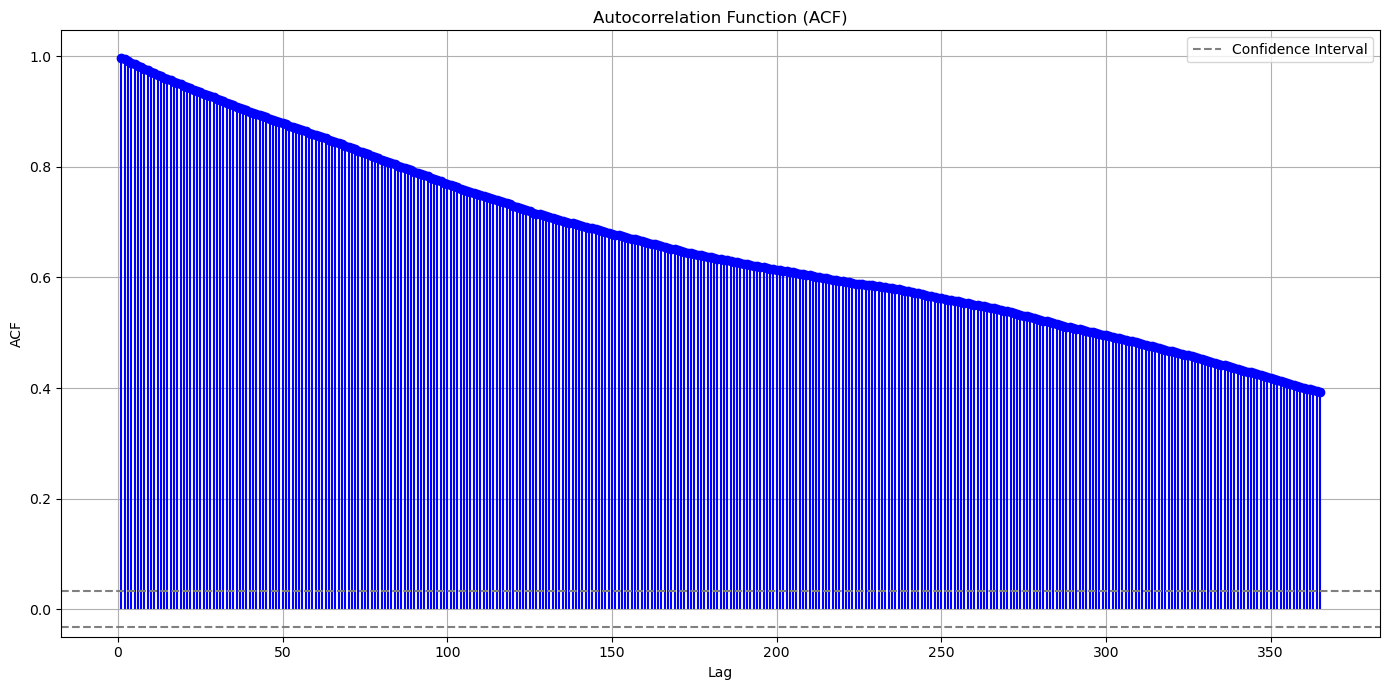

2024-10-22 17:45:07,380 - INFO - No significant seasonality detected.


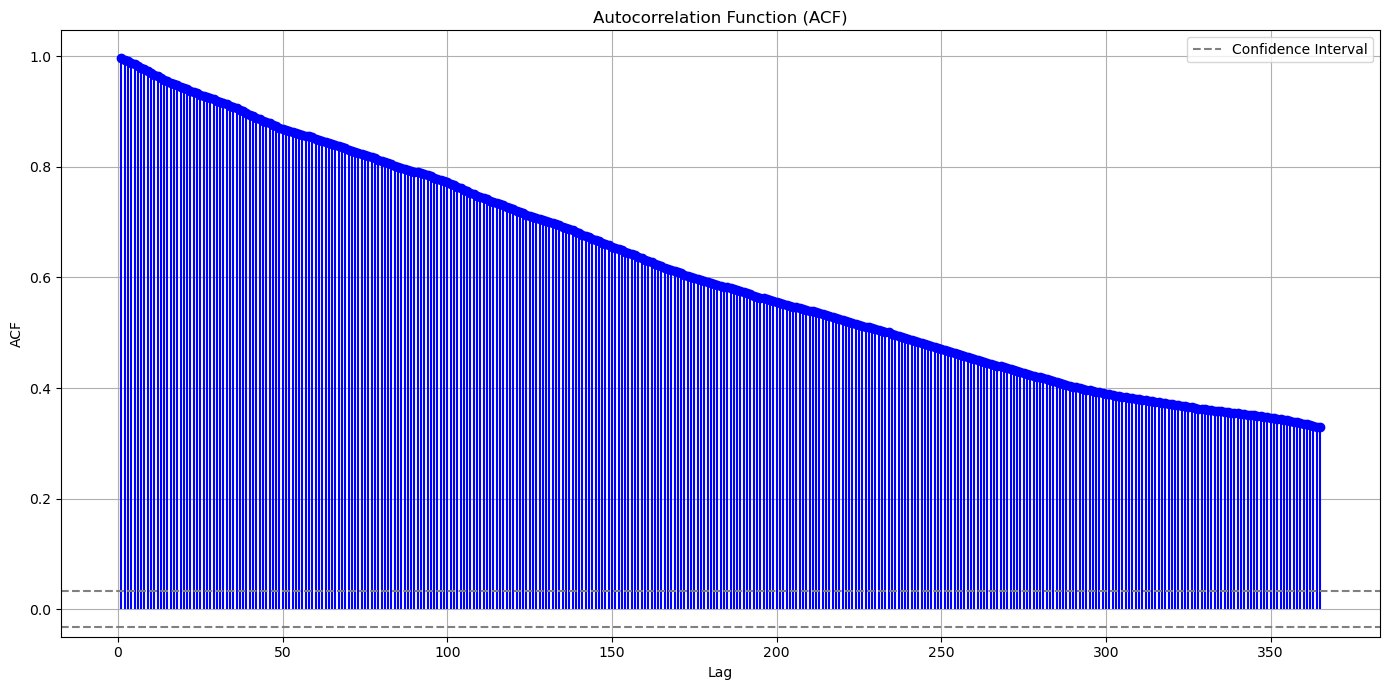

In [9]:
def find_optimal_seasonal_period(series, max_seasonal_period=365):
    """
    Determines the optimal seasonal period for a time series using autocorrelation analysis.
    Always plots the ACF and identified peaks for visual inspection.

    Parameters:
        series (pd.Series): The time series data.
        max_seasonal_period (int): The maximum seasonal period to consider.

    Returns:
        int or None: The suggested optimal seasonal period. Returns None if no seasonality is detected.
    """
    try:
        # Remove NaN values
        series = series.dropna()
        n = len(series)

        # Compute ACF up to max_seasonal_period
        lag_acf = acf(series, nlags=max_seasonal_period, fft=True)

        # Confidence interval for ACF
        conf_level = 1.96 / np.sqrt(n)

        # Find peaks in ACF that exceed the confidence interval
        peaks, properties = find_peaks(
            lag_acf[1:], height=conf_level)  # Exclude lag 0
        peaks = peaks + 1  # Adjust lag since ACF starts at lag 0

        if len(peaks) == 0:
            logging.info("No significant seasonality detected.")
            optimal_lag = None
        else:
            # Select the peak with the highest autocorrelation
            peak_heights = properties['peak_heights']
            optimal_lag = peaks[np.argmax(peak_heights)]
            logging.info(f"Optimal seasonal period detected: {optimal_lag}")

        # Plot the ACF with detected peaks
        plt.figure(figsize=(14, 7))
        plt.stem(range(1, max_seasonal_period + 1),
                 lag_acf[1:], linefmt='b-', markerfmt='bo', basefmt=' ')
        plt.axhline(y=conf_level, linestyle='--',
                    color='gray', label='Confidence Interval')
        plt.axhline(y=-conf_level, linestyle='--', color='gray')
        if len(peaks) > 0:
            plt.scatter(peaks, lag_acf[peaks],
                        color='red', label='Detected Peaks')
        plt.title('Autocorrelation Function (ACF)')
        plt.xlabel('Lag')
        plt.ylabel('ACF')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return optimal_lag

    except Exception as e:
        logging.error(f"An error occurred in finding seasonal period: {e}")
        return None
    
find_optimal_seasonal_period(gld_data['Close'])

find_optimal_seasonal_period(slv_data['Close'])

# Analyzing ACF Plots with Straight Line Negative Slopes

When performing **Autocorrelation Function (ACF)** analysis to determine the optimal seasonal period in time series data, the shape and behavior of the ACF plot provide critical insights into the underlying patterns of the series. A common scenario to encounter is an ACF plot that exhibits a **straight line with a negative slope**. Understanding and interpreting this pattern is essential for accurate seasonality detection and subsequent modeling.

## **Understanding the Straight Line Negative Slope in ACF Plots**

### **1. What Does a Straight Line Negative Slope Indicate?**

A **straight line with a negative slope** in an ACF plot typically suggests the presence of a **trend** in the time series rather than seasonality. Here's why:

- **Trend Presence:**
  - **Consistent Decline:**  
    A negative slope indicates that as the lag increases, the autocorrelation decreases in a consistent manner. This pattern is characteristic of a **non-stationary series with a deterministic trend**.
  
  - **No Seasonal Peaks:**  
    Unlike seasonal patterns, which produce **significant peaks** at specific lags corresponding to the seasonal period, a straight declining line lacks these prominent spikes.

### **2. Implications for Seasonality Detection**

- **Absence of Seasonality:**
  - The lack of significant peaks in the ACF plot implies that there is **no strong seasonal component** in the data.
  
  - **Non-Seasonal Trend:**  
    The observed trend is **non-seasonal**, meaning that the series exhibits a consistent upward or downward movement over time without repeating cyclical patterns.

- **Modeling Considerations:**
  - **Seasonal Differencing May Be Unnecessary:**  
    Since the ACF plot does not indicate seasonality, applying seasonal differencing might not be beneficial and could potentially overcomplicate the model.
  
  - **Focus on Trend Differencing:**  
    Instead of seasonal differencing, consider applying **regular differencing** to remove the trend and achieve stationarity.

## **Step-by-Step Analysis Approach**

1. **Visual Inspection of the ACF Plot:**
   - **Identify Slope Pattern:**  
     Observe whether the ACF plot shows a straight declining line without significant peaks.
   
   - **Determine Significance:**  
     Assess if the autocorrelations lie within the confidence intervals. A consistently declining pattern outside these bounds reinforces the presence of a trend.

2. **Complementary Stationarity Tests:**
   - **Augmented Dickey-Fuller (ADF) Test:**  
     Confirms the presence of a unit root (non-stationarity) if the null hypothesis is not rejected.
   
   - **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
     Checks for stationarity around a trend. A failure to reject the null hypothesis supports the presence of a trend.

3. **Apply Regular Differencing:**
   - **First-Order Differencing:**  
     Apply differencing to remove the trend component.
   
   - **Re-evaluate Stationarity:**  
     Perform stationarity tests again to ensure that the differenced series is now stationary.

4. **Re-analyze ACF Plot Post-Differencing:**
   - **Check for Remaining Patterns:**  
     After removing the trend, the ACF plot should ideally show no significant autocorrelations, indicating stationarity.


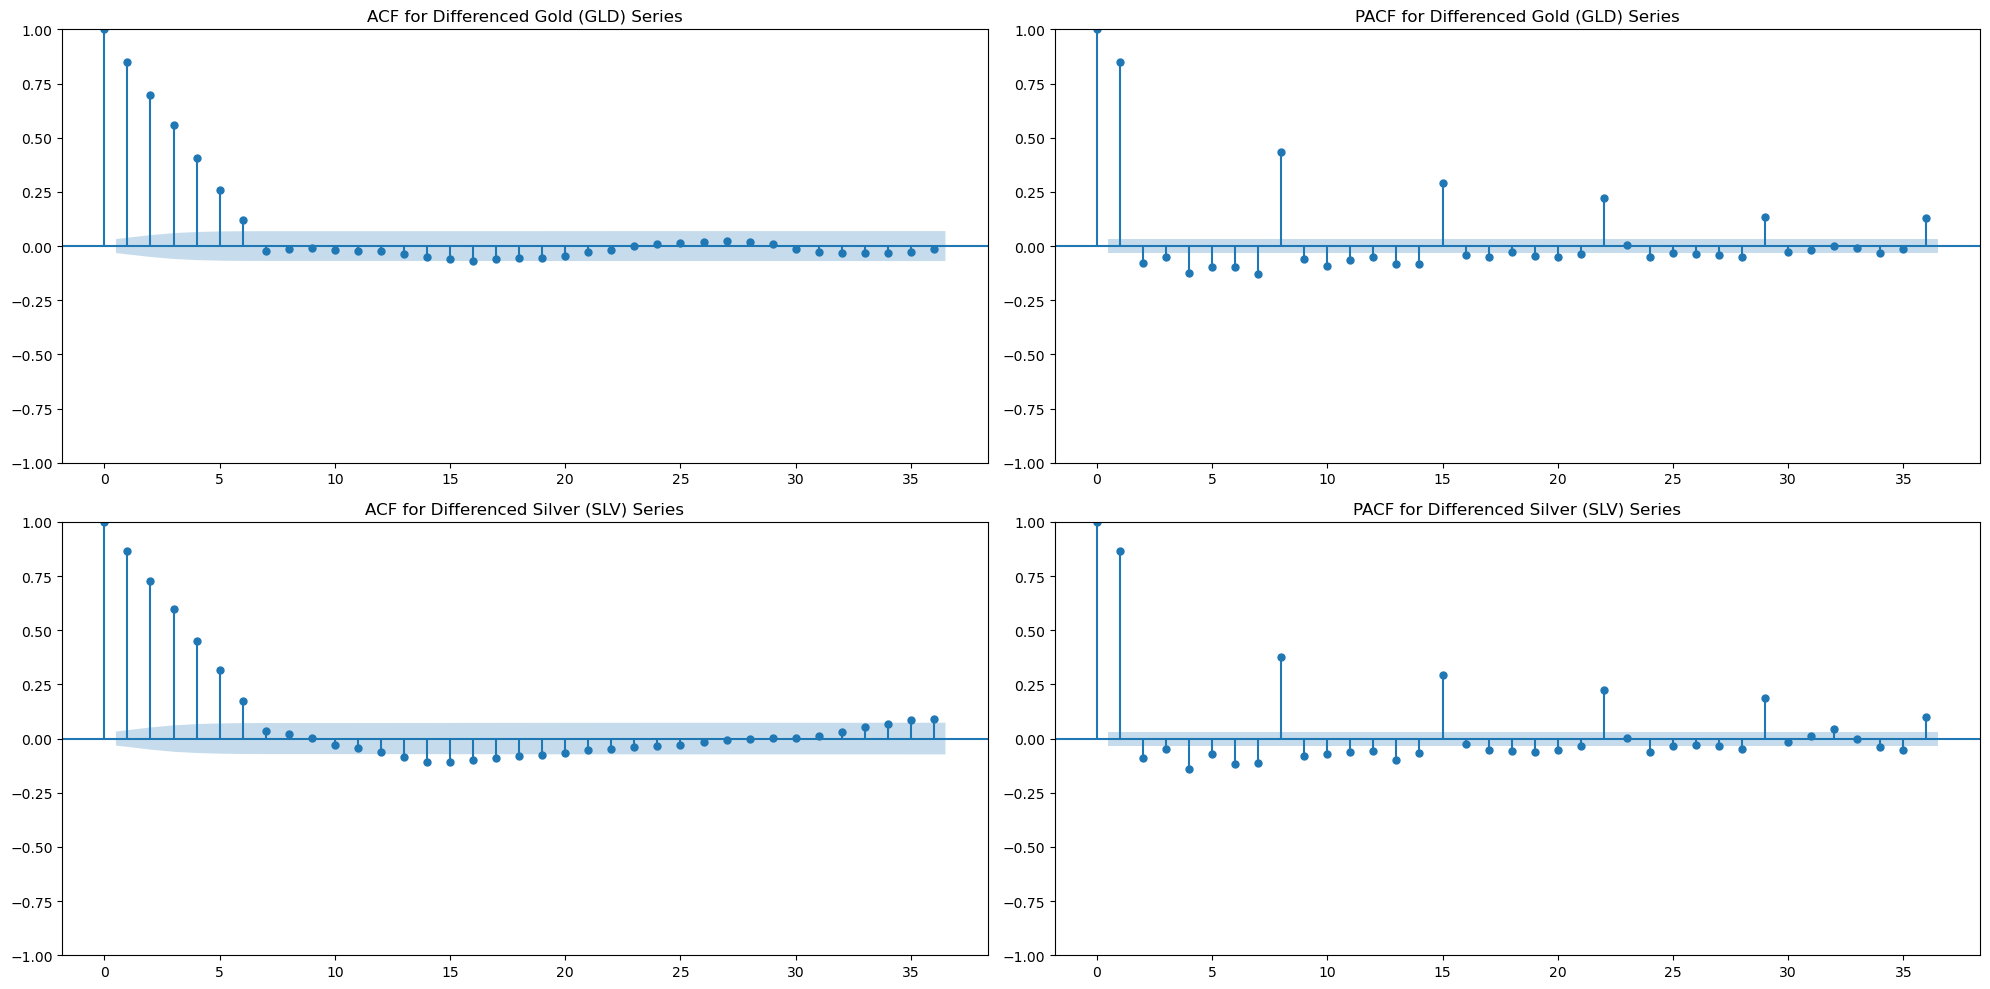

In [10]:

if gld_data is None or slv_data is None:
    logging.error("Data fetching failed. Exiting the plotting function.")

seasonal_period = 7  # For weekly seasonality in daily data

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# ACF and PACF for Gold (GLD)
plot_acf(gld_data['Close'].diff(seasonal_period).dropna(), ax=axes[0, 0])
axes[0, 0].set_title("ACF for Differenced Gold (GLD) Series")
plot_pacf(gld_data['Close'].diff(seasonal_period).dropna(), ax=axes[0, 1])
axes[0, 1].set_title("PACF for Differenced Gold (GLD) Series")

# ACF and PACF for Silver (SLV)
plot_acf(slv_data['Close'].diff(seasonal_period).dropna(), ax=axes[1, 0])
axes[1, 0].set_title("ACF for Differenced Silver (SLV) Series")
plot_pacf(slv_data['Close'].diff(seasonal_period).dropna(), ax=axes[1, 1])
axes[1, 1].set_title("PACF for Differenced Silver (SLV) Series")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Autocorrelation and Partial Autocorrelation Analysis for Gold (GLD) and Silver (SLV)

In this section, we analyze the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots for the **Gold (GLD)** and **Silver (SLV)** time series data. These analyses help us uncover underlying patterns and dependencies, which are essential for building effective forecasting models.


2024-10-22 17:45:08,307 - INFO - Performing seasonal differencing with period=14...
2024-10-22 17:45:08,308 - INFO - Seasonal differencing completed.
2024-10-22 17:45:08,516 - INFO - Performing seasonal differencing with period=14...
2024-10-22 17:45:08,523 - INFO - Seasonal differencing completed.


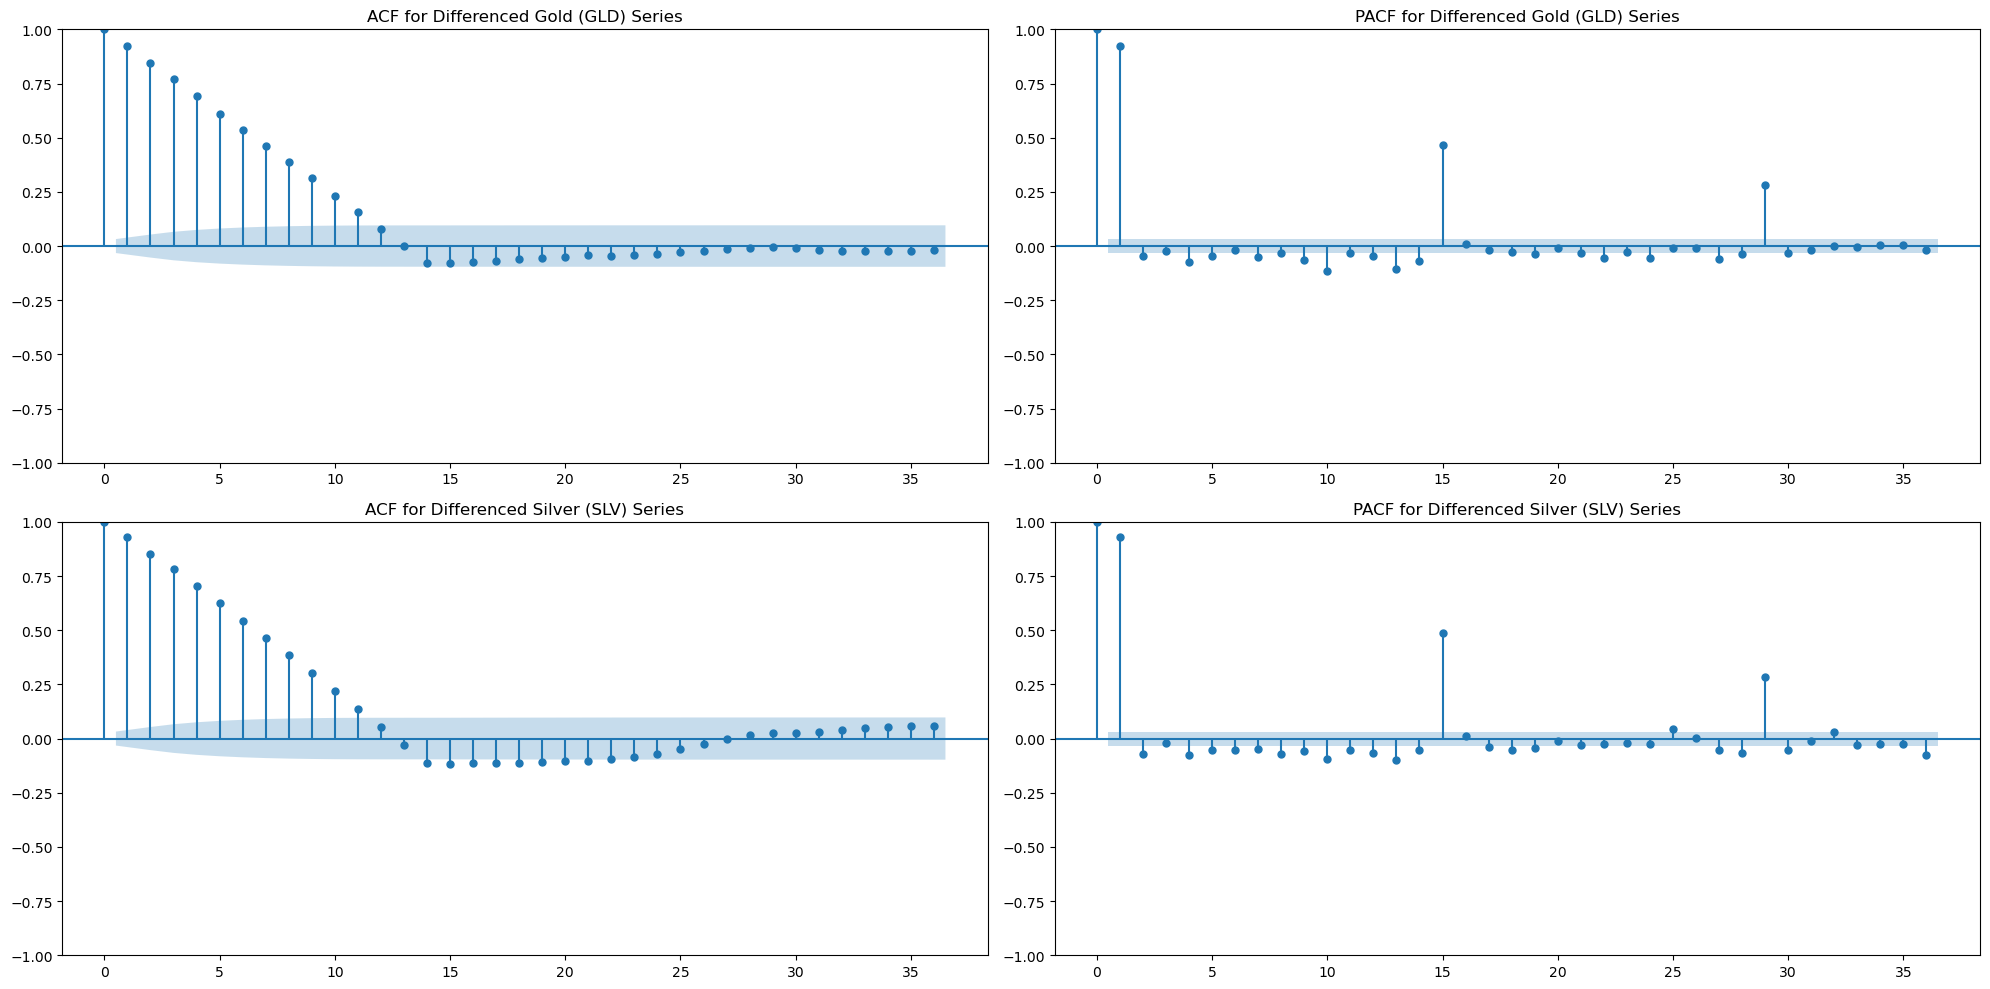

In [11]:
def plot_acf_pacf(series, seasonal_period, title_prefix, axes):
    """
    Plots ACF and PACF for a given time series after seasonal differencing.

    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The number of periods in a season.
        title_prefix (str): Prefix for the plot titles (e.g., 'Gold (GLD)').
        axes (array): Array of matplotlib axes to plot on.
    """
    differenced = seasonal_differencing(series, seasonal_period)
    if differenced is None:
        logging.warning(
            f"Plotting ACF/PACF skipped for {title_prefix}: No data after differencing.")
        return

    plot_acf(differenced, ax=axes[0])
    axes[0].set_title(f"ACF for Differenced {title_prefix} Series")

    plot_pacf(differenced, ax=axes[1])
    axes[1].set_title(f"PACF for Differenced {title_prefix} Series")


# Create a 2x2 grid for Gold and Silver
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plot for Gold
plot_acf_pacf(gld_data['Close'], 14, "Gold (GLD)", axes[0])

# Plot for Silver
plot_acf_pacf(slv_data['Close'], 14, "Silver (SLV)", axes[1])

plt.tight_layout()
plt.show()

# Seasonal Decomposition of Gold (GLD) and Silver (SLV) Time Series

In this section, we perform **seasonal decomposition** on the time series data for **Gold (GLD)** and **Silver (SLV)**. Seasonal decomposition breaks down a time series into its fundamental components, allowing for a clearer understanding of underlying patterns and trends. This process is essential for building accurate forecasting models.

## **Purpose of Seasonal Decomposition**

Seasonal decomposition separates a time series into three main components:

1. **Trend:** The long-term progression or movement in the data.
2. **Seasonality:** Regular, repeating patterns or cycles within the data.
3. **Residuals:** Random noise or irregular fluctuations remaining after removing trend and seasonality.

By isolating these components, we can analyze each aspect individually, enhancing our ability to model and forecast future values effectively.

2024-10-22 17:47:18,026 - INFO - Performing seasonal decomposition with period=7 and model='additive'...
2024-10-22 17:47:18,063 - INFO - Seasonal decomposition completed.


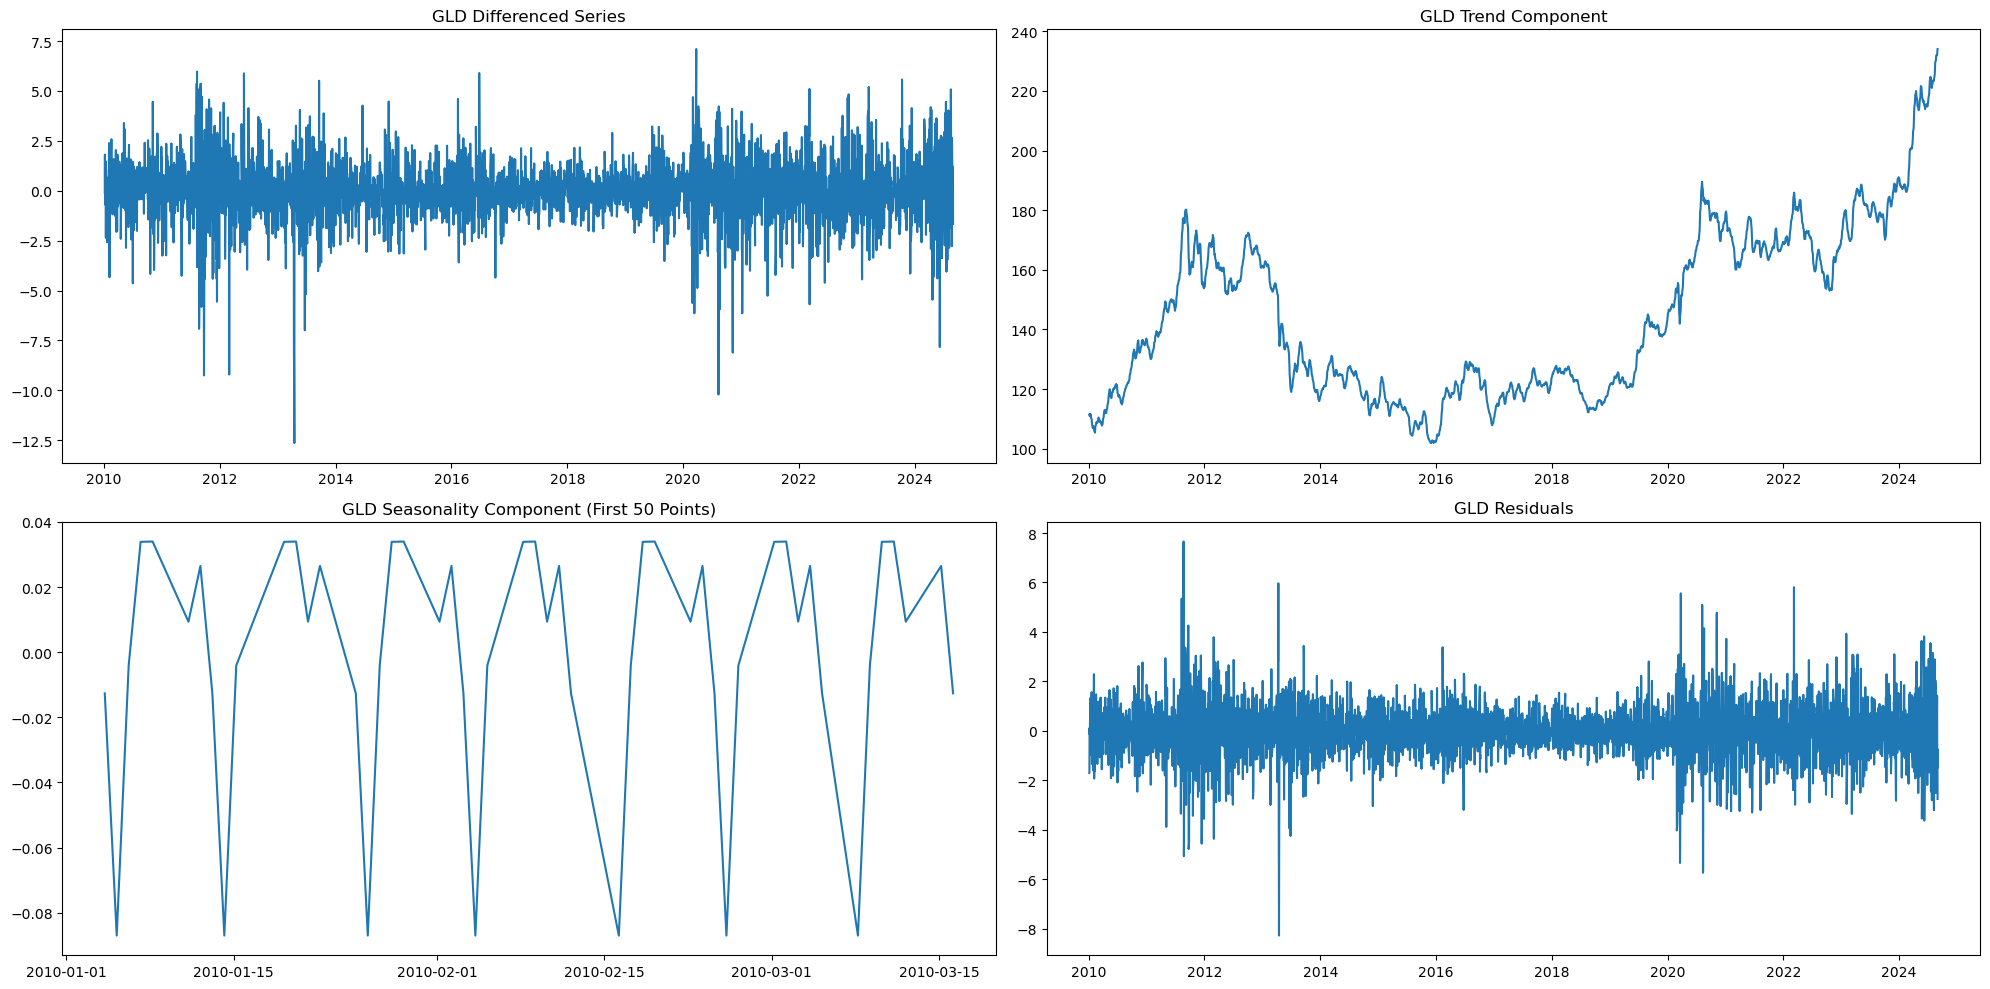

2024-10-22 17:47:18,664 - INFO - Performing seasonal decomposition with period=7 and model='additive'...
2024-10-22 17:47:18,666 - INFO - Seasonal decomposition completed.


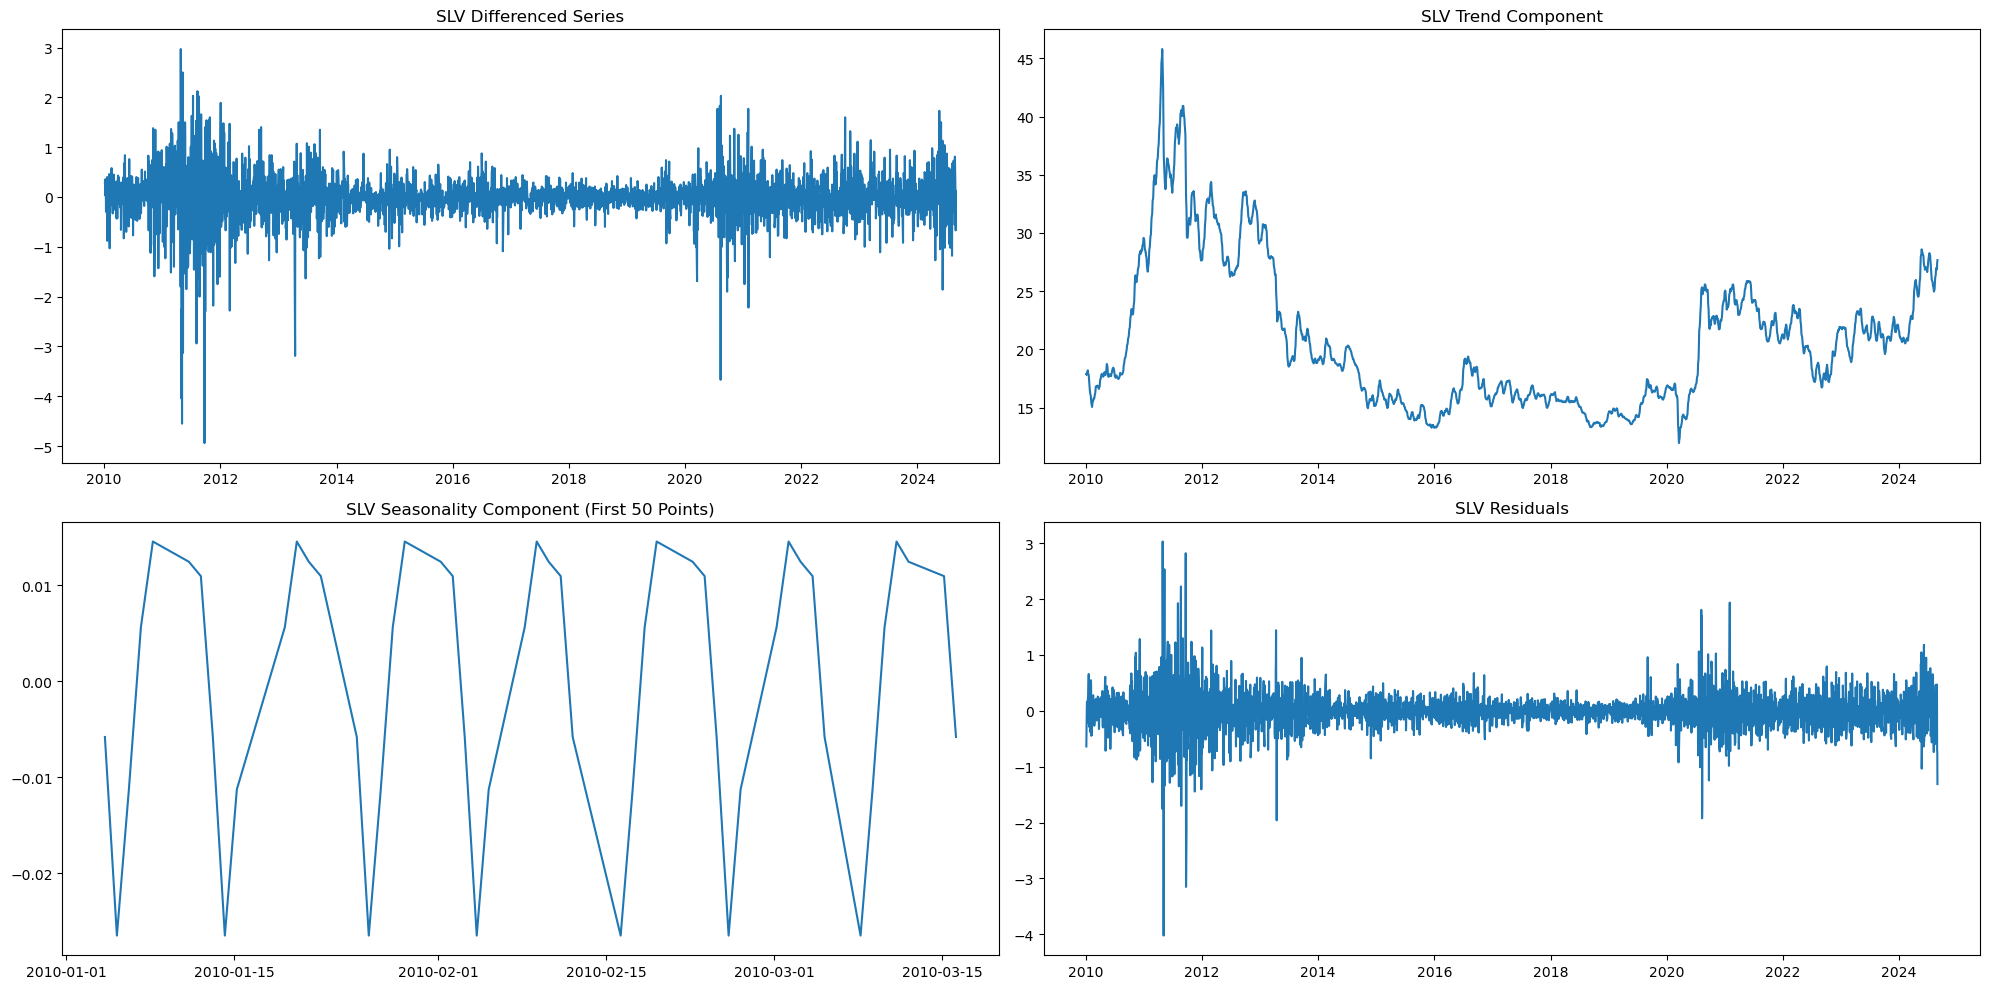

In [23]:
def plot_seasonal_decomposition(ts, ticker, seasonal_period=7):
    decomposition = seasonal_decomposition_analysis(ts, seasonal_period)

    if decomposition is None:
        logging.warning(
            f"Seasonal decomposition plot skipped for {ticker}: No valid decomposition.")
        return

    trend = decomposition.trend
    seasonality = decomposition.seasonal
    resid = decomposition.resid

    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(ts.diff().dropna())
    ax1.set_title(f"{ticker} Differenced Series")

    ax2.plot(trend)
    ax2.set_title(f"{ticker} Trend Component")

    ax3.plot(seasonality[:50])
    ax3.set_title(f"{ticker} Seasonality Component (First 50 Points)")

    ax4.plot(resid)
    ax4.set_title(f"{ticker} Residuals")

    plt.tight_layout()
    plt.show()
    return trend, seasonality, resid


# Assuming 'gld_data' and 'slv_data' are fetched and contain a 'Close' column for close prices
trend_gld, seasonality_gld, resid_gld = plot_seasonal_decomposition(gld_data['Close'], 'GLD', seasonal_period=7)
trend_slv, seasonality_slv, resid_slv = plot_seasonal_decomposition(
    slv_data['Close'], 'SLV',seasonal_period=7)

# Autocorrelation and Partial Autocorrelation Analysis for Trend and Seasonality Components

In this section, we analyze the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** for the **trend** and **seasonality** components of the **Gold (GLD)** and **Silver (SLV)** time series. Understanding these plots helps us identify patterns and dependencies, which are crucial for building accurate forecasting models.

## **1. Purpose of ACF and PACF Analysis**

- **Autocorrelation Function (ACF):**  
  Measures the correlation between the time series and its lagged values. It helps identify repeating patterns or cycles in the data.

- **Partial Autocorrelation Function (PACF):**  
  Measures the correlation between the time series and its lagged values while controlling for the correlations at shorter lags. It helps determine the direct relationships between observations.

## **2. Decomposed Components**

Before analyzing ACF and PACF, we decompose the time series into its fundamental components:

1. **Trend:**  
   The long-term movement or direction in the data (e.g., increasing or decreasing prices).

2. **Seasonality:**  
   Regular, repeating patterns or cycles within the data (e.g., weekly or monthly fluctuations).

3. **Residuals:**  
   Random noise or irregular fluctuations remaining after removing trend and seasonality.

## **3. Plotting ACF and PACF for Each Component**

The provided function `plot_acf_pacf_for_series` creates ACF and PACF plots for both the trend and seasonality components of GLD and SLV. Here's how it works conceptually:

### **a. Gold (GLD) Analysis**

- **Trend Component:**
  - **ACF Plot:**  
    Shows how the trend is correlated with its past values. Look for significant autocorrelations at various lags, which indicate persistent trends.
  
  - **PACF Plot:**  
    Highlights the direct influence of past trend values on the current trend. Significant spikes suggest the order of autoregressive terms needed in modeling.

- **Seasonality Component:**
  - **ACF Plot:**  
    Reveals repeating seasonal patterns by showing correlations at seasonal lags (e.g., every 7 days for weekly seasonality).
  
  - **PACF Plot:**  
    Identifies the direct seasonal dependencies, helping to determine the appropriate seasonal AR terms in the model.

### **b. Silver (SLV) Analysis**

- **Trend Component:**
  - **ACF Plot:**  
    Similar to GLD, it displays how the trend in SLV is related to its past values. Significant lags indicate strong trend persistence.
  
  - **PACF Plot:**  
    Shows the direct impact of past trend values on the current trend, aiding in selecting AR terms.

- **Seasonality Component:**
  - **ACF Plot:**  
    Detects regular seasonal patterns by highlighting significant correlations at seasonal lags.
  
  - **PACF Plot:**  
    Helps in pinpointing the direct seasonal effects, guiding the inclusion of seasonal AR terms in the model.

## **4. What to Look For in the ACF and PACF Plots**

- **Significant Peaks:**
  - **Above Confidence Intervals:**  
    Spikes that exceed the confidence bounds indicate significant autocorrelations at those lags.
  
  - **Pattern Recognition:**  
    Regularly spaced peaks at seasonal lags confirm the presence of seasonality.

- **Decay Patterns:**
  - **Gradual Decay in ACF:**  
    Suggests a persistent trend in the data.
  
  - **Sharp Cutoffs in PACF:**  
    Help determine the number of AR terms needed in the model.

- **Seasonal Lags:**
  - **Recurring Spikes:**  
    For example, spikes at lag 7 in daily data indicate weekly seasonality.




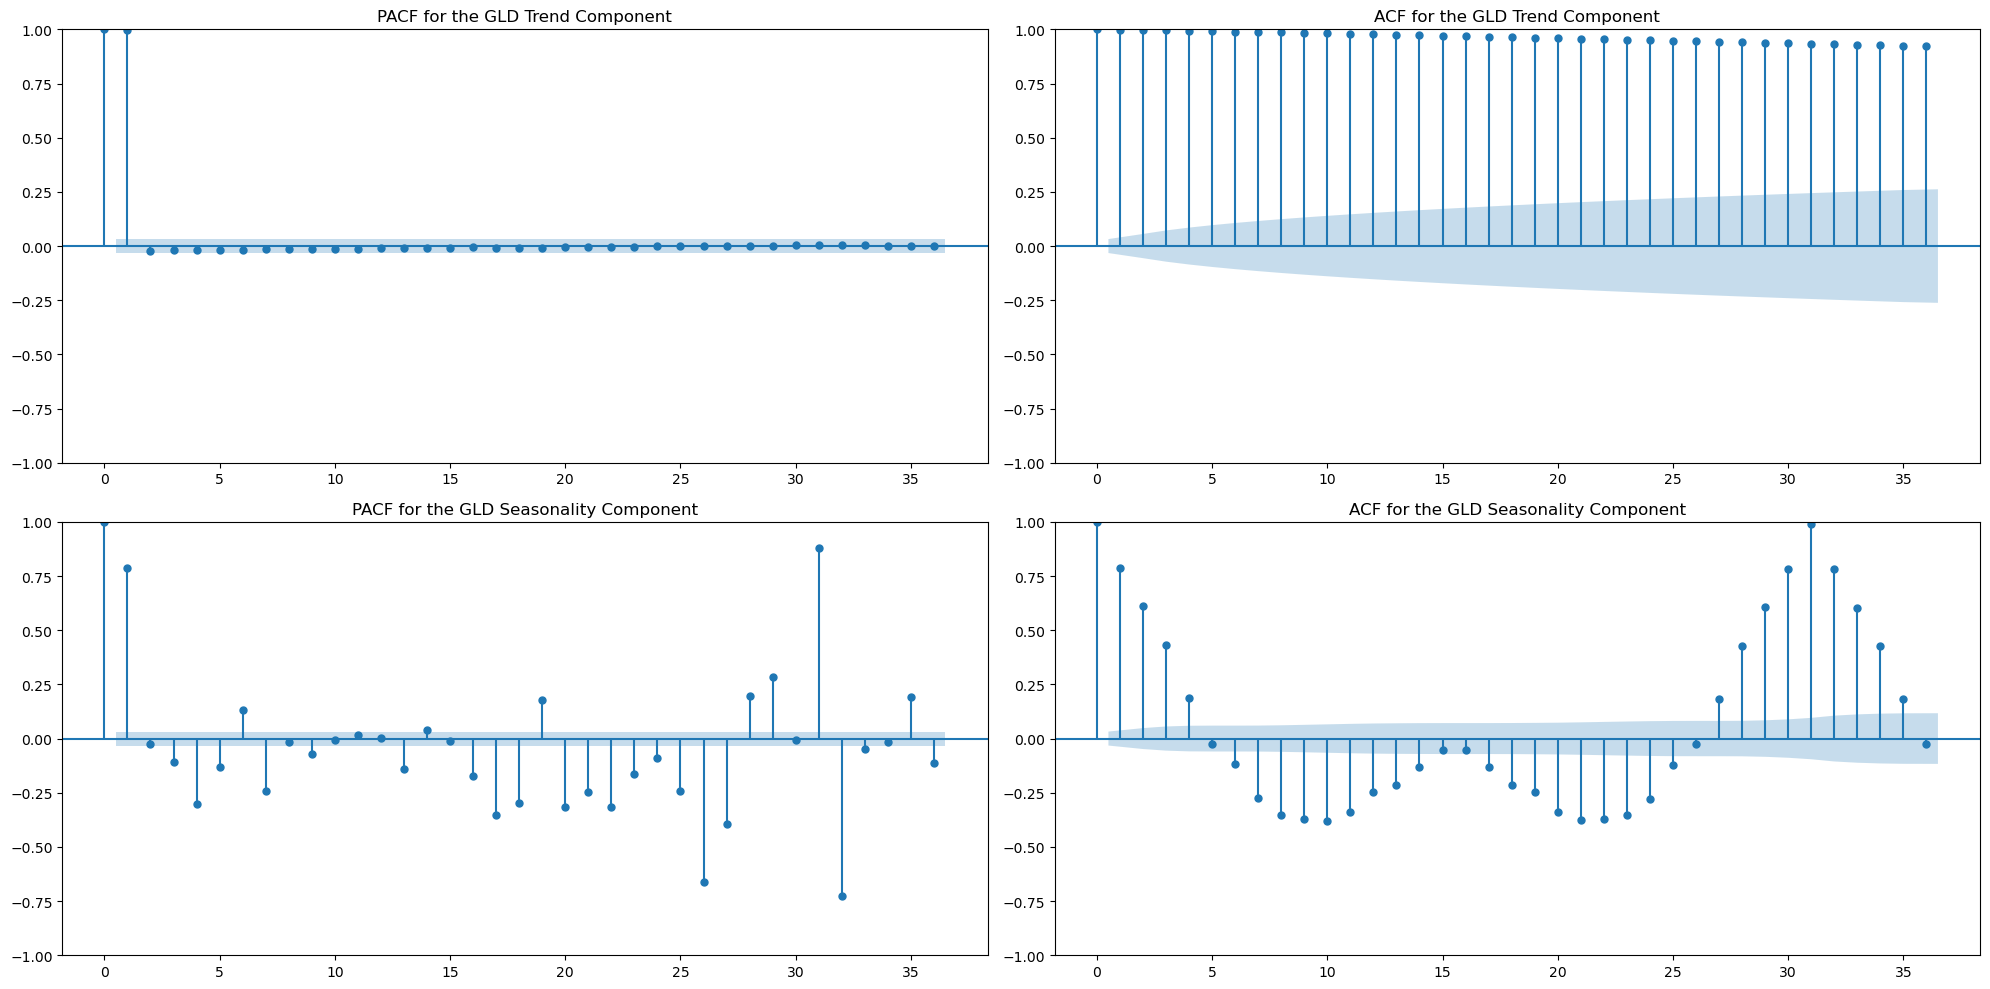

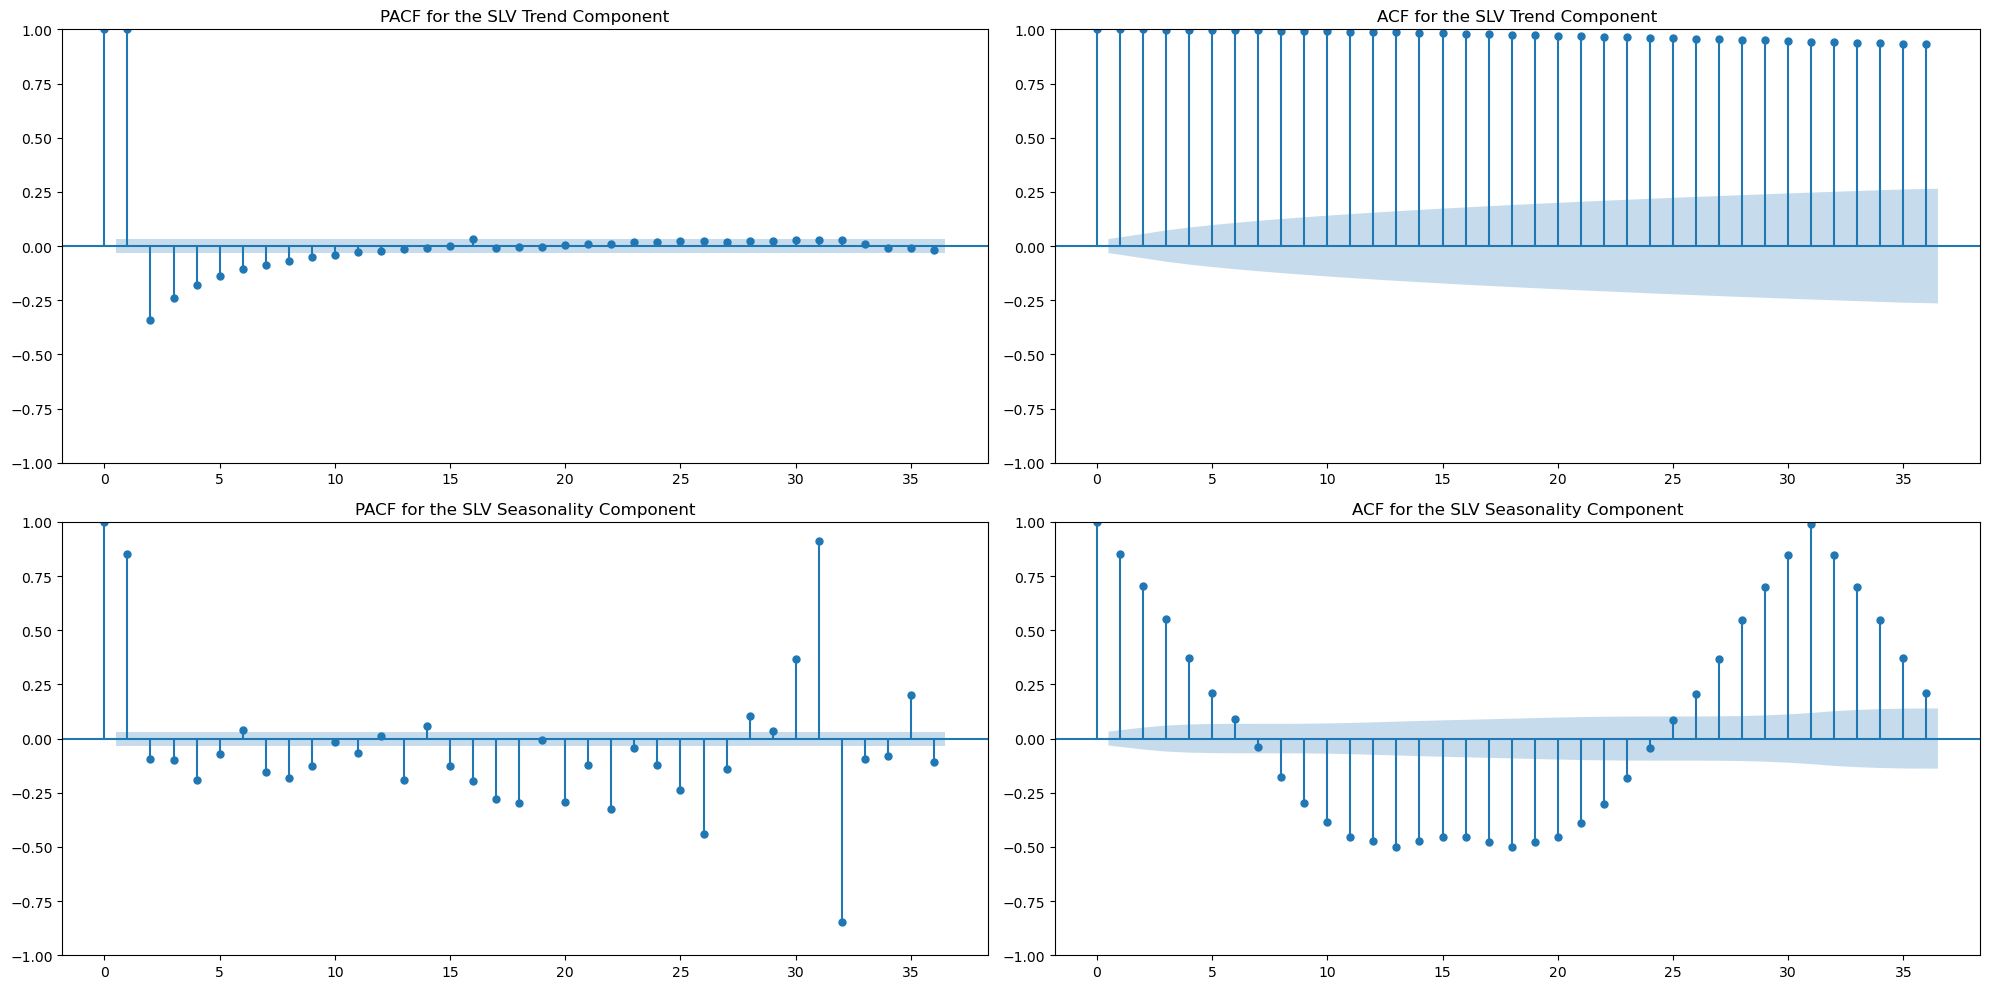

In [13]:
def plot_acf_pacf_for_series(trend_gld, seasonality_gld, trend_slv, seasonality_slv):
    """
    Plots ACF and PACF for the trend and seasonality components of Gold (GLD) and Silver (SLV) time series.

    Parameters:
        trend_gld (pd.Series): Trend component of GLD.
        seasonality_gld (pd.Series): Seasonality component of GLD.
        trend_slv (pd.Series): Trend component of SLV.
        seasonality_slv (pd.Series): Seasonality component of SLV.
    """
    try:
        # Create a figure for Gold (GLD)
        fig_gld = plt.figure(figsize=(20, 10))

        # PACF for GLD Trend
        ax1 = fig_gld.add_subplot(2, 2, 1)
        plot_pacf(trend_gld.dropna(), ax=ax1)
        ax1.set_title("PACF for the GLD Trend Component")

        # ACF for GLD Trend
        ax2 = fig_gld.add_subplot(2, 2, 2)
        plot_acf(trend_gld.dropna(), ax=ax2)
        ax2.set_title("ACF for the GLD Trend Component")

        # PACF for GLD Seasonality
        ax3 = fig_gld.add_subplot(2, 2, 3)
        plot_pacf(seasonality_gld, ax=ax3)
        ax3.set_title("PACF for the GLD Seasonality Component")

        # ACF for GLD Seasonality
        ax4 = fig_gld.add_subplot(2, 2, 4)
        plot_acf(seasonality_gld, ax=ax4)
        ax4.set_title("ACF for the GLD Seasonality Component")

        plt.tight_layout()
        plt.show()

        # Create a figure for Silver (SLV)
        fig_slv = plt.figure(figsize=(20, 10))

        # PACF for SLV Trend
        ax5 = fig_slv.add_subplot(2, 2, 1)
        plot_pacf(trend_slv.dropna(), ax=ax5)
        ax5.set_title("PACF for the SLV Trend Component")

        # ACF for SLV Trend
        ax6 = fig_slv.add_subplot(2, 2, 2)
        plot_acf(trend_slv.dropna(), ax=ax6)
        ax6.set_title("ACF for the SLV Trend Component")

        # PACF for SLV Seasonality
        ax7 = fig_slv.add_subplot(2, 2, 3)
        plot_pacf(seasonality_slv, ax=ax7)
        ax7.set_title("PACF for the SLV Seasonality Component")

        # ACF for SLV Seasonality
        ax8 = fig_slv.add_subplot(2, 2, 4)
        plot_acf(seasonality_slv, ax=ax8)
        ax8.set_title("ACF for the SLV Seasonality Component")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        logging.error(f"An error occurred while plotting ACF and PACF: {e}")


# Now, plot ACF and PACF for both
plot_acf_pacf_for_series(trend_gld, seasonality_gld,
                         trend_slv, seasonality_slv)

/var/folders/2c/trmbhl295p74b6v9kd24x24h0000gn/T/ipykernel_72159/3048652519.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='ct', nlags="auto")


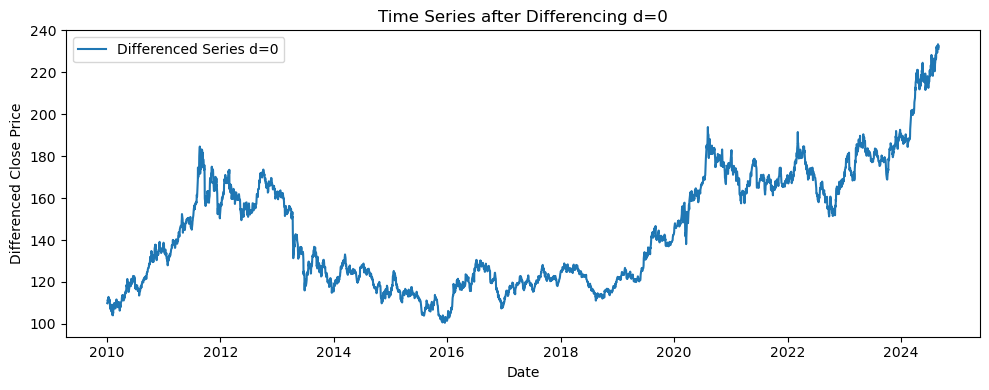

/var/folders/2c/trmbhl295p74b6v9kd24x24h0000gn/T/ipykernel_72159/3048652519.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='ct', nlags="auto")


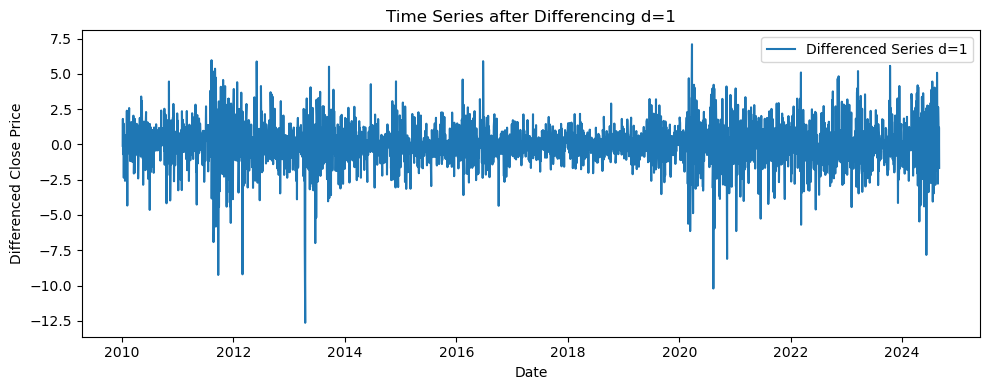

/var/folders/2c/trmbhl295p74b6v9kd24x24h0000gn/T/ipykernel_72159/3048652519.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='ct', nlags="auto")


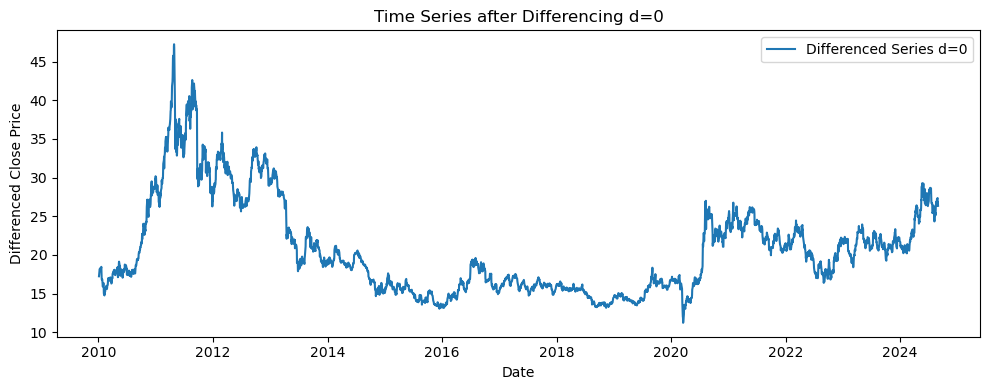

/var/folders/2c/trmbhl295p74b6v9kd24x24h0000gn/T/ipykernel_72159/3048652519.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='ct', nlags="auto")


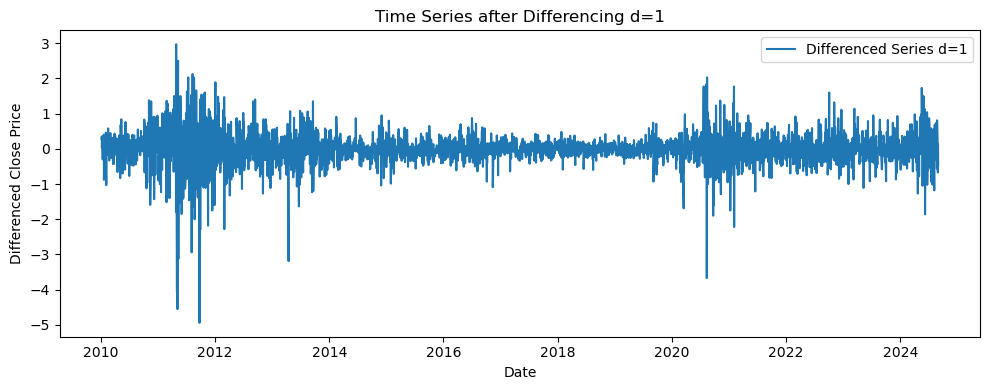

{'GLD_d': 1, 'SLV_d': 1}

In [14]:
def test_stationarity(series, signif=0.05, name='', verbose=False):
    """
    Perform Augmented Dickey-Fuller and KPSS tests to check stationarity.

    Parameters:
        series (pd.Series): The time series to test.
        signif (float): Significance level for the tests.
        name (str): Name of the series (for logging purposes).
        verbose (bool): If True, print detailed test results.

    Returns:
        dict: Results of the stationarity tests.
    """
    results = {}

    # Augmented Dickey-Fuller Test
    adf_test = adfuller(series, autolag='AIC')
    adf_pvalue = adf_test[1]
    adf_stat = adf_test[0]
    results['ADF_stat'] = adf_stat
    results['ADF_pvalue'] = adf_pvalue

    # KPSS Test
    try:
        kpss_test = kpss(series, regression='ct', nlags="auto")
        kpss_pvalue = kpss_test[1]
        kpss_stat = kpss_test[0]
        results['KPSS_stat'] = kpss_stat
        results['KPSS_pvalue'] = kpss_pvalue
    except ValueError as e:
        logging.error(f"KPSS test failed for {name}: {e}")
        results['KPSS_stat'] = None
        results['KPSS_pvalue'] = None

    if verbose:
        print(f'\nStationarity Test Results for {name}:')
        print(
            'ADF Statistic: {:.4f}, p-value: {:.4f}'.format(adf_stat, adf_pvalue))
        if results['KPSS_pvalue'] is not None:
            print(
                'KPSS Statistic: {:.4f}, p-value: {:.4f}'.format(kpss_stat, kpss_pvalue))
        else:
            print('KPSS Test could not be performed.')

    return results


def determine_optimal_differencing(series, max_d=4, signif=0.05, verbose=False):
    """
    Determine the optimal differencing order 'd' for a time series to achieve stationarity.
    Also plots the series after each differencing step.

    Parameters:
        series (pd.Series): The time series to analyze.
        max_d (int): Maximum number of differencing steps to try.
        signif (float): Significance level for the stationarity tests.
        verbose (bool): If True, print detailed information during the process.

    Returns:
        int: Optimal differencing order 'd'.
    """
    d = 0
    current_series = series.copy()

    while d <= max_d:
        if verbose:
            print(f'\nDifferencing Order d={d}')

        # Perform stationarity tests
        test_results = test_stationarity(
            current_series, signif=signif, name=f'Differenced Series d={d}', verbose=verbose)

        adf_pvalue = test_results['ADF_pvalue']
        kpss_pvalue = test_results['KPSS_pvalue']

        # ADF Test: Null hypothesis is non-stationary
        adf_stationary = adf_pvalue < signif

        # KPSS Test: Null hypothesis is stationary
        kpss_stationary = kpss_pvalue >= signif if kpss_pvalue is not None else False

        if verbose:
            print(
                f'ADF Stationary: {adf_stationary}, KPSS Stationary: {kpss_stationary}')

        # Plot the current differenced series
        plt.figure(figsize=(10, 4))
        plt.plot(current_series, label=f'Differenced Series d={d}')
        plt.title(f'Time Series after Differencing d={d}')
        plt.xlabel('Date')
        plt.ylabel('Differenced Close Price')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # If both tests agree on stationarity, return current d
        if adf_stationary and kpss_stationary:
            if verbose:
                print(f'\nOptimal differencing order determined: d={d}')
            return d

        # If not stationary, difference the series
        if d < max_d:
            current_series = current_series.diff().dropna()
            d += 1
            if verbose:
                print(f'Applying differencing to achieve stationarity...')
        else:
            if verbose:
                print(f'\nReached maximum differencing order d={max_d}.')
            return d


def determine_optimal_differencing_for_gld_slv(gld_data, slv_data, max_d=4, signif=0.05, verbose=False):
    """
    Determine the optimal differencing order 'd' for both Gold (GLD) and Silver (SLV) datasets.
    Also plots the time series after each differencing step.

    Parameters:
        gld_data (pd.DataFrame): DataFrame containing GLD historical data with a 'c' column.
        slv_data (pd.DataFrame): DataFrame containing SLV historical data with a 'c' column.
        max_d (int): Maximum number of differencing steps to try.
        signif (float): Significance level for the stationarity tests.
        verbose (bool): If True, print detailed information during the process.

    Returns:
        dict: Optimal differencing orders for GLD and SLV.
    """
    results = {}

    # Ensure 'c' column exists for GLD
    if 'Close' not in gld_data.columns:
        logging.error("GLD data does not contain a 'Close' column.")
        results['GLD_d'] = None
    else:
        if verbose:
            print("\nDetermining optimal differencing for Gold (GLD):")
        gld_series = gld_data['Close']
        gld_d = determine_optimal_differencing(
            gld_series, max_d=max_d, signif=signif, verbose=verbose)
        results['GLD_d'] = gld_d

    # Ensure 'c' column exists for SLV
    if 'Close' not in slv_data.columns:
        logging.error("SLV data does not contain a 'Close' column.")
        results['SLV_d'] = None
    else:
        if verbose:
            print("\nDetermining optimal differencing for Silver (SLV):")
        slv_series = slv_data['Close']
        slv_d = determine_optimal_differencing(
            slv_series, max_d=max_d, signif=signif, verbose=verbose)
        results['SLV_d'] = slv_d

    return results

determine_optimal_differencing_for_gld_slv(gld_data, slv_data)

In [15]:


def find_optimal_ma_term(series, max_lag=20, plot=False):
    """
    Find the optimal MA term using the ACF (Autocorrelation Function).
    
    Parameters:
        series (pd.Series): The time series data.
        max_lag (int): The maximum number of lags to consider for the ACF.
        plot (bool): Whether to plot the ACF for visualization.
        
    Returns:
        int: The optimal MA term.
    """
    # Compute the ACF for the time series
    acf_values = acf(series, nlags=max_lag, fft=True)
    
    # Plot the ACF if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plot_acf(series, lags=max_lag)
        plt.title('Autocorrelation Function (ACF)')
        plt.show()
    
    # Find the lag where the ACF cuts off
    # A good rule of thumb is to find the first significant drop in the ACF
    cutoff_lag = next((i for i, v in enumerate(acf_values) if v < 0), 1)
    
    return cutoff_lag


In [16]:


def find_optimal_ar_term(series, max_lag=20, plot=False):
    """
    Find the optimal AR term using the PACF (Partial Autocorrelation Function).
    
    Parameters:
        series (pd.Series): The time series data.
        max_lag (int): The maximum number of lags to consider for the PACF.
        plot (bool): Whether to plot the PACF for visualization.
        
    Returns:
        int: The optimal AR term.
    """
    # Compute the PACF for the time series
    pacf_values = pacf(series, nlags=max_lag)

    # Plot the PACF if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plot_pacf(series, lags=max_lag)
        plt.title('Partial Autocorrelation Function (PACF)')
        plt.show()

    # Find the lag where the PACF cuts off
    # A good rule of thumb is to find the first significant drop in the PACF
    cutoff_lag = next((i for i, v in enumerate(pacf_values) if v < 0), 1)

    return cutoff_lag

<Figure size 1000x600 with 0 Axes>

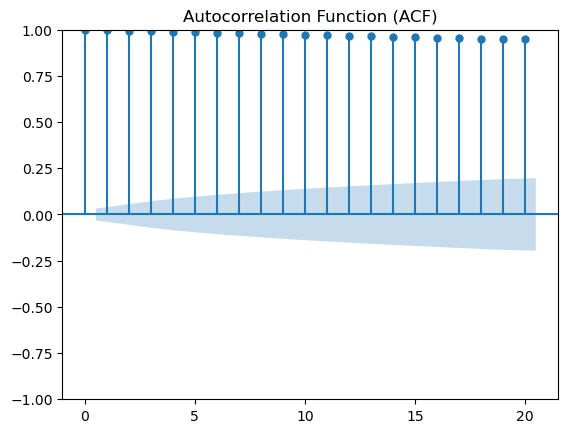

<Figure size 1000x600 with 0 Axes>

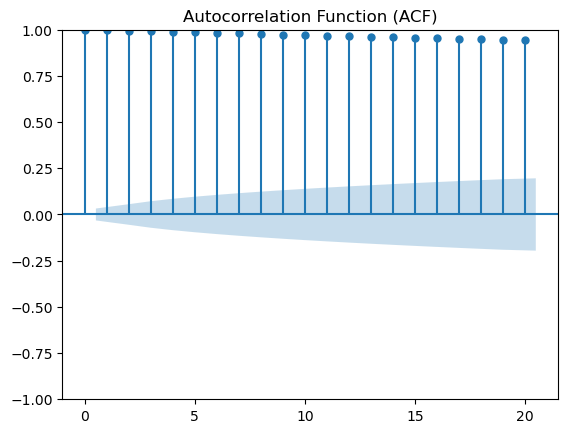

NameError: name 'pacf' is not defined

In [24]:
# Assuming `gld_data` and `slv_data` are the dataframes with a 'Close' column for the closing prices
gld_close = gld_data['Close']
slv_close = slv_data['Close']

# Find optimal MA term for GLD and SLV
optimal_ma_gld = find_optimal_ma_term(gld_close, max_lag=20, plot=True)
optimal_ma_slv = find_optimal_ma_term(slv_close, max_lag=20, plot=True)

# Find optimal AR term for GLD and SLV
optimal_ar_gld = find_optimal_ar_term(gld_close, max_lag=20, plot=True)
optimal_ar_slv = find_optimal_ar_term(slv_close, max_lag=20, plot=True)

print(f"Optimal MA for GLD: {optimal_ma_gld}")
print(f"Optimal MA for SLV: {optimal_ma_slv}")
print(f"Optimal AR for GLD: {optimal_ar_gld}")
print(f"Optimal AR for SLV: {optimal_ar_slv}")

In [104]:
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

from statsmodels.tsa.stattools import pacf


def find_optimal_seasonal_ar(series, seasonal_period, max_lag=20, plot=False):
    """
    Find the optimal seasonal AR (P) term using the PACF (Partial Autocorrelation Function).
    
    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The seasonal period (e.g., 7 for weekly seasonality).
        max_lag (int): The maximum number of lags to consider for the PACF.
        plot (bool): Whether to plot the PACF for visualization.
        
    Returns:
        int: The optimal seasonal AR term (P).
    """
    seasonal_diff_series = series.diff(seasonal_period).dropna()

    # Compute the PACF for the seasonally differenced series
    pacf_values = pacf(seasonal_diff_series, nlags=max_lag)

    if plot:
        plt.figure(figsize=(10, 6))
        plot_pacf(seasonal_diff_series, lags=max_lag)
        plt.title('Partial Autocorrelation Function (Seasonally Differenced)')
        plt.show()

    # Find the first significant lag where PACF cuts off
    cutoff_lag = next((i for i, v in enumerate(pacf_values) if v < 0), 1)

    return cutoff_lag


def find_optimal_seasonal_ma(series, seasonal_period, max_lag=20, plot=False):
    """
    Find the optimal seasonal MA (Q) term using the ACF (Autocorrelation Function).
    
    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The seasonal period (e.g., 7 for weekly seasonality).
        max_lag (int): The maximum number of lags to consider for the ACF.
        plot (bool): Whether to plot the ACF for visualization.
        
    Returns:
        int: The optimal seasonal MA term (Q).
    """
    seasonal_diff_series = series.diff(seasonal_period).dropna()

    # Compute the ACF for the seasonally differenced series
    acf_values = acf(seasonal_diff_series, nlags=max_lag, fft=True)

    if plot:
        plt.figure(figsize=(10, 6))
        plot_acf(seasonal_diff_series, lags=max_lag)
        plt.title('Autocorrelation Function (Seasonally Differenced)')
        plt.show()

    # Find the first significant lag where ACF cuts off
    cutoff_lag = next((i for i, v in enumerate(acf_values) if v < 0), 1)

    return cutoff_lag


def find_optimal_seasonal_d(series, seasonal_period, signif=0.05):
    """
    Find the optimal seasonal differencing (D) term using the ADF test.
    
    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The seasonal period (e.g., 7 for weekly seasonality).
        signif (float): The significance level for the ADF test (default 0.05).
        
    Returns:
        int: The optimal seasonal differencing term (D) (0 or 1).
    """
    # Seasonal differencing
    seasonal_diff_series = series.diff(seasonal_period).dropna()

    # Perform the Augmented Dickey-Fuller test
    adf_test = adfuller(seasonal_diff_series)

    # Check if the series is stationary (p-value < significance level)
    p_value = adf_test[1]
    if p_value < signif:
        return 1  # Need seasonal differencing
    else:
        return 0  # No seasonal differencing needed


def find_optimal_seasonal_period(series, max_lag=365, plot=False):
    """
    Find the optimal seasonal period (s) using the ACF (Autocorrelation Function).
    
    Parameters:
        series (pd.Series): The time series data.
        max_lag (int): The maximum number of lags to consider for the ACF.
        plot (bool): Whether to plot the ACF for visualization.
        
    Returns:
        int: The optimal seasonal period (s).
    """
    # Compute the ACF for the time series
    acf_values = acf(series, nlags=max_lag, fft=True)

    # Plot the ACF if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plot_acf(series, lags=max_lag)
        plt.title('Autocorrelation Function (ACF)')
        plt.show()

    # Find peaks in the ACF that likely represent the seasonal period
    peaks, _ = find_peaks(acf_values[1:], height=0)
    if len(peaks) > 0:
        # Adjust for 0-based indexing in find_peaks
        optimal_period = peaks[0] + 1
    else:
        optimal_period = 1  # Default to 1 if no significant peak is found

    return optimal_period

<Figure size 1000x600 with 0 Axes>

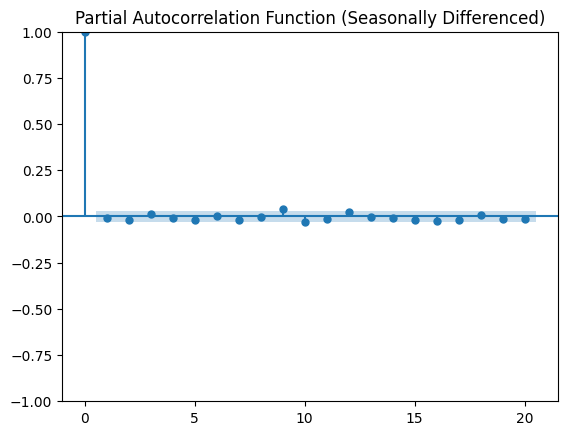

<Figure size 1000x600 with 0 Axes>

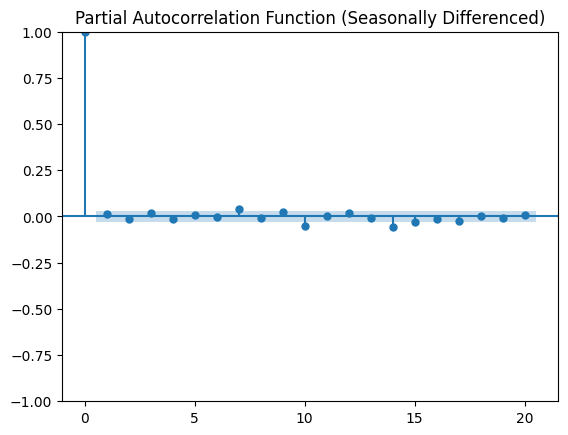

<Figure size 1000x600 with 0 Axes>

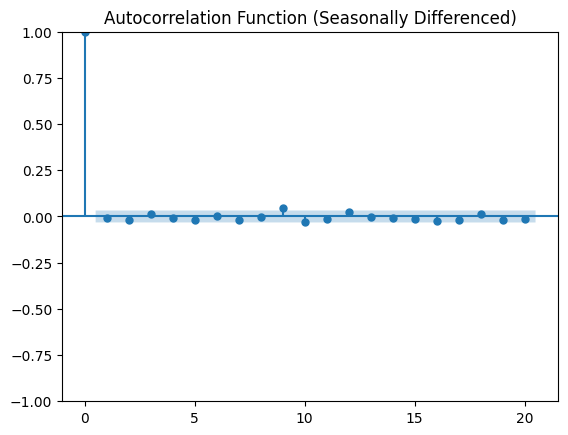

<Figure size 1000x600 with 0 Axes>

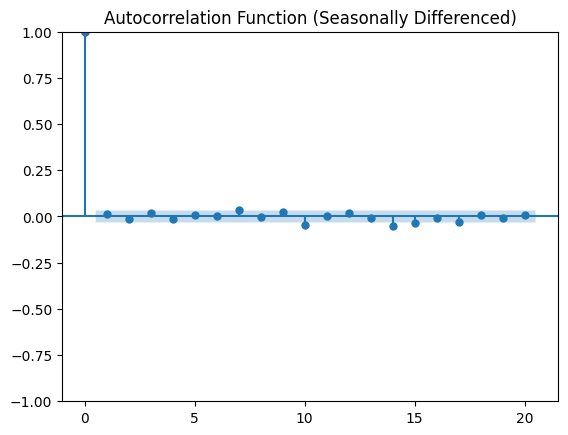

<Figure size 1000x600 with 0 Axes>

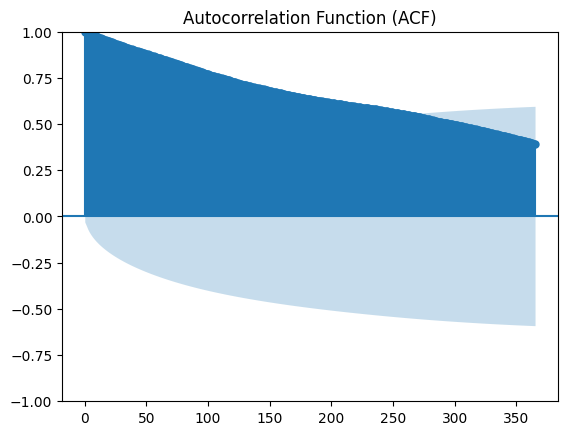

<Figure size 1000x600 with 0 Axes>

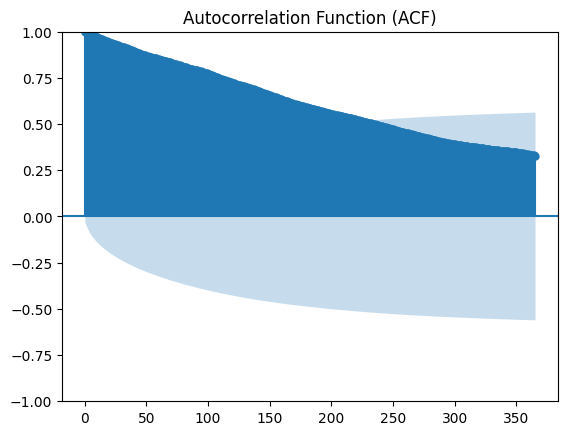

Optimal Seasonal AR for GLD: 1
Optimal Seasonal MA for GLD: 1
Optimal Seasonal D for GLD: 1
Optimal Seasonal Period for GLD: 1
Optimal Seasonal AR for SLV: 2
Optimal Seasonal MA for SLV: 2
Optimal Seasonal D for SLV: 1
Optimal Seasonal Period for SLV: 1


In [105]:
# Assuming `gld_close` and `slv_close` are the closing price time series for GLD and SLV

# Find optimal seasonal AR (P) term
optimal_seasonal_ar_gld = find_optimal_seasonal_ar(
    gld_close, seasonal_period=1, plot=True)
optimal_seasonal_ar_slv = find_optimal_seasonal_ar(
    slv_close, seasonal_period=1, plot=True)

# Find optimal seasonal MA (Q) term
optimal_seasonal_ma_gld = find_optimal_seasonal_ma(
    gld_close, seasonal_period=1, plot=True)
optimal_seasonal_ma_slv = find_optimal_seasonal_ma(
    slv_close, seasonal_period=1, plot=True)

# Find optimal seasonal differencing (D) term
optimal_seasonal_d_gld = find_optimal_seasonal_d(gld_close, seasonal_period=7)
optimal_seasonal_d_slv = find_optimal_seasonal_d(slv_close, seasonal_period=7)

# Find optimal seasonal period (s)
optimal_seasonal_period_gld = find_optimal_seasonal_period(
    gld_close, max_lag=365, plot=True)
optimal_seasonal_period_slv = find_optimal_seasonal_period(
    slv_close, max_lag=365, plot=True)

print(f"Optimal Seasonal AR for GLD: {optimal_seasonal_ar_gld}")
print(f"Optimal Seasonal MA for GLD: {optimal_seasonal_ma_gld}")
print(f"Optimal Seasonal D for GLD: {optimal_seasonal_d_gld}")
print(f"Optimal Seasonal Period for GLD: {optimal_seasonal_period_gld}")

print(f"Optimal Seasonal AR for SLV: {optimal_seasonal_ar_slv}")
print(f"Optimal Seasonal MA for SLV: {optimal_seasonal_ma_slv}")
print(f"Optimal Seasonal D for SLV: {optimal_seasonal_d_slv}")
print(f"Optimal Seasonal Period for SLV: {optimal_seasonal_period_slv}")

In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Split the data into training and testing sets
train_size = int(len(gld_data) * 0.8)
train_data, test_data = gld_data['Close'][:
                                          train_size], gld_data['Close'][train_size:]

# Define the SARIMA model with appropriate order and seasonal order
sarima_order = (2, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, s) with weekly seasonality

# Fit the SARIMA model on the training data
model = SARIMAX(train_data, order=sarima_order, seasonal_order=seasonal_order, enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = model.fit()

# Print the summary of the model fit
print(sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56321D+00    |proj g|=  2.83888D-01


 This problem is unconstrained.



At iterate    5    f=  1.83634D+00    |proj g|=  2.83477D-01

At iterate   10    f=  1.76905D+00    |proj g|=  1.95317D-01

At iterate   15    f=  1.75660D+00    |proj g|=  2.21305D-02

At iterate   20    f=  1.75639D+00    |proj g|=  6.37247D-03

At iterate   25    f=  1.75639D+00    |proj g|=  1.98542D-03

At iterate   30    f=  1.75634D+00    |proj g|=  3.35336D-02

At iterate   35    f=  1.75620D+00    |proj g|=  6.01362D-03

At iterate   40    f=  1.75613D+00    |proj g|=  3.32178D-03

At iterate   45    f=  1.75609D+00    |proj g|=  3.05092D-03

At iterate   50    f=  1.75606D+00    |proj g|=  3.63682D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [159]:
# Generate forecasts for the test set
forecast_steps = len(test_data)
forecast = sarima_fit.get_forecast(steps=forecast_steps)
predicted_mean = forecast.predicted_mean

In [160]:
mse = mean_squared_error(test_data, predicted_mean)
mae = mean_absolute_error(test_data, predicted_mean)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 377.16157361084777
Mean Absolute Error (MAE): 13.884501812528217


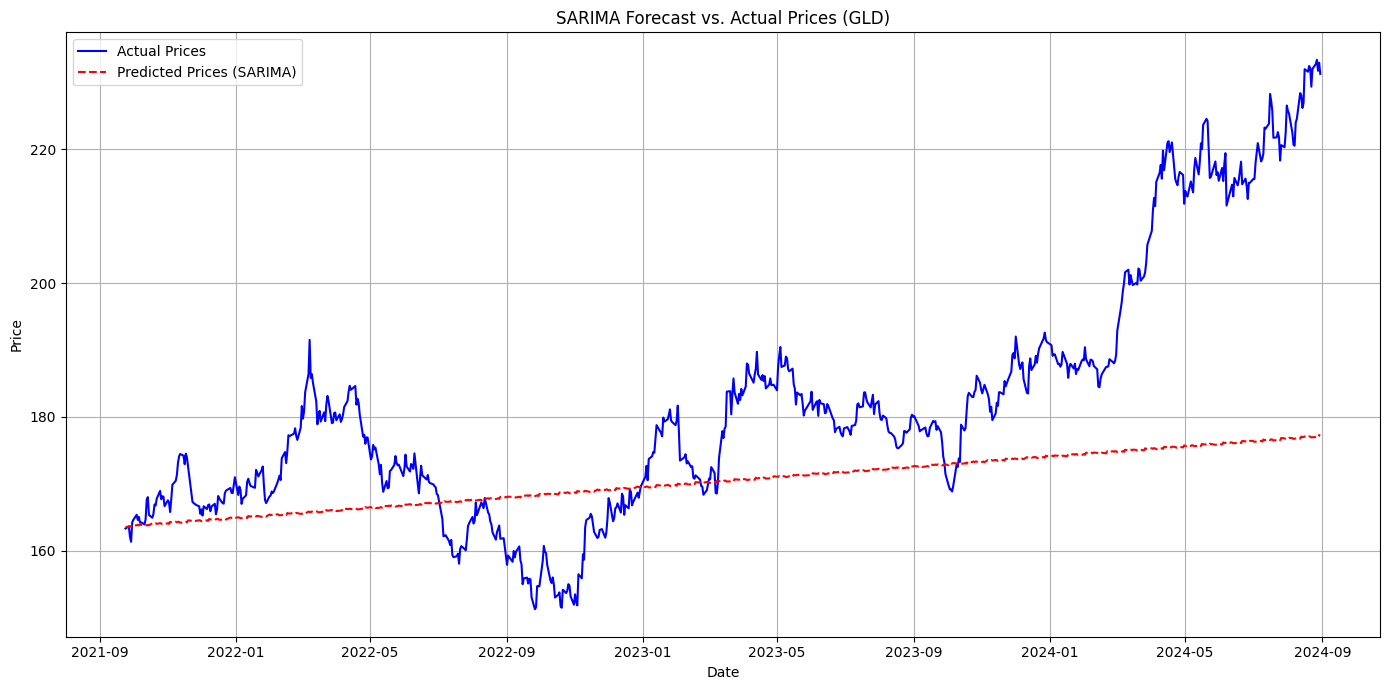

In [158]:
# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data, label='Actual Prices', color='blue')
plt.plot(test_data.index, predicted_mean,
         label='Predicted Prices (SARIMA)', color='red', linestyle='--')
plt.title('SARIMA Forecast vs. Actual Prices (GLD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()